## SETUP

In [1]:
## docker: docker_slim
source('./../../../../my_utils/funcs_R/my_rutils.R')
source("./../../helper_funs.r")
suppressMessages(suppressWarnings(library(DESeq2)))
suppressMessages(suppressWarnings(library(edgeR)))
suppressMessages(suppressWarnings(library(sctransform)))
suppressMessages(suppressWarnings(library(RColorBrewer)))
suppressMessages(suppressWarnings(library(gplots)))

save.dir <- './figs/figs_feb_27_fpfn/'

# font size for figures
fs <-  4 
fs.small <- 3

## GET DATA

In [2]:
data.dir <- './../../../data/seqFISH_kidney/'
counts.fname <- paste0(data.dir, 'SG_MouseKidneyDataRelease_CxG_section1.csv')
pos.fname <- paste0(data.dir,'SG_MouseKidneyDataRelease_CellCoordinates_section1.csv')

counts <- read.csv(counts.fname, row.names = 1)
meta <- read.csv('meta_regions.csv', row.names = 1)
pos <- meta[,c('center_x','center_y')]
region <- meta[,'region']
names(region) <- rownames(meta)

## remove cells in 'other' region
cells <- rownames(meta[meta$region != 'other',])
length(cells)
# cells <- rownames(meta)

counts <- counts[cells,]
meta <- meta[cells,]
pos <- pos[cells,]
region <- region[cells]

dim(counts)

[1] 252900

[1] 252900    221

In [3]:
# ## downsample for testing -- comment out later 
# set.seed(0)
# cells <- sample(rownames(counts), 10000)

# counts <- counts[cells,]

In [4]:
#remove cells and genes with 0 counts
genes <- colSums(counts)>0
counts <- counts[,genes]
cells <- cells[rowSums(counts)>0]
counts <- counts[cells,]

meta <- meta[cells,]
pos <- pos[cells,]
region <- region[cells]

dim(counts)
dim(meta)
dim(pos)
length(region)

[1] 252553    219

[1] 252553      4

[1] 252553      2

[1] 252553

In [5]:
sum(rowSums(counts)==0)
sum(colSums(counts)==0)

[1] 0

[1] 0

In [6]:
## coloring all regions 
col.region <- fac2col(region)
names(col.region) <- names(region)
table(region)
table(col.region)
leg.col.region.og <- unique(col.region)
names(leg.col.region.og) <- unique(meta$region)


region
 cortex medulla  pelvis 
 109084   44554   98915 

col.region
#0000FF #00FF00 #FF0000 
  98915   44554  109084 

In [7]:
## make legend 
#all regions colored
leg.col.region <- unique(col.region)
names(leg.col.region) <- unique(region)
table(meta$region)
table(col.region)
leg.col.region


 cortex medulla  pelvis 
 109084   44554   98915 

col.region
#0000FF #00FF00 #FF0000 
  98915   44554  109084 

cortex   medulla    pelvis 
"#FF0000" "#00FF00" "#0000FF"

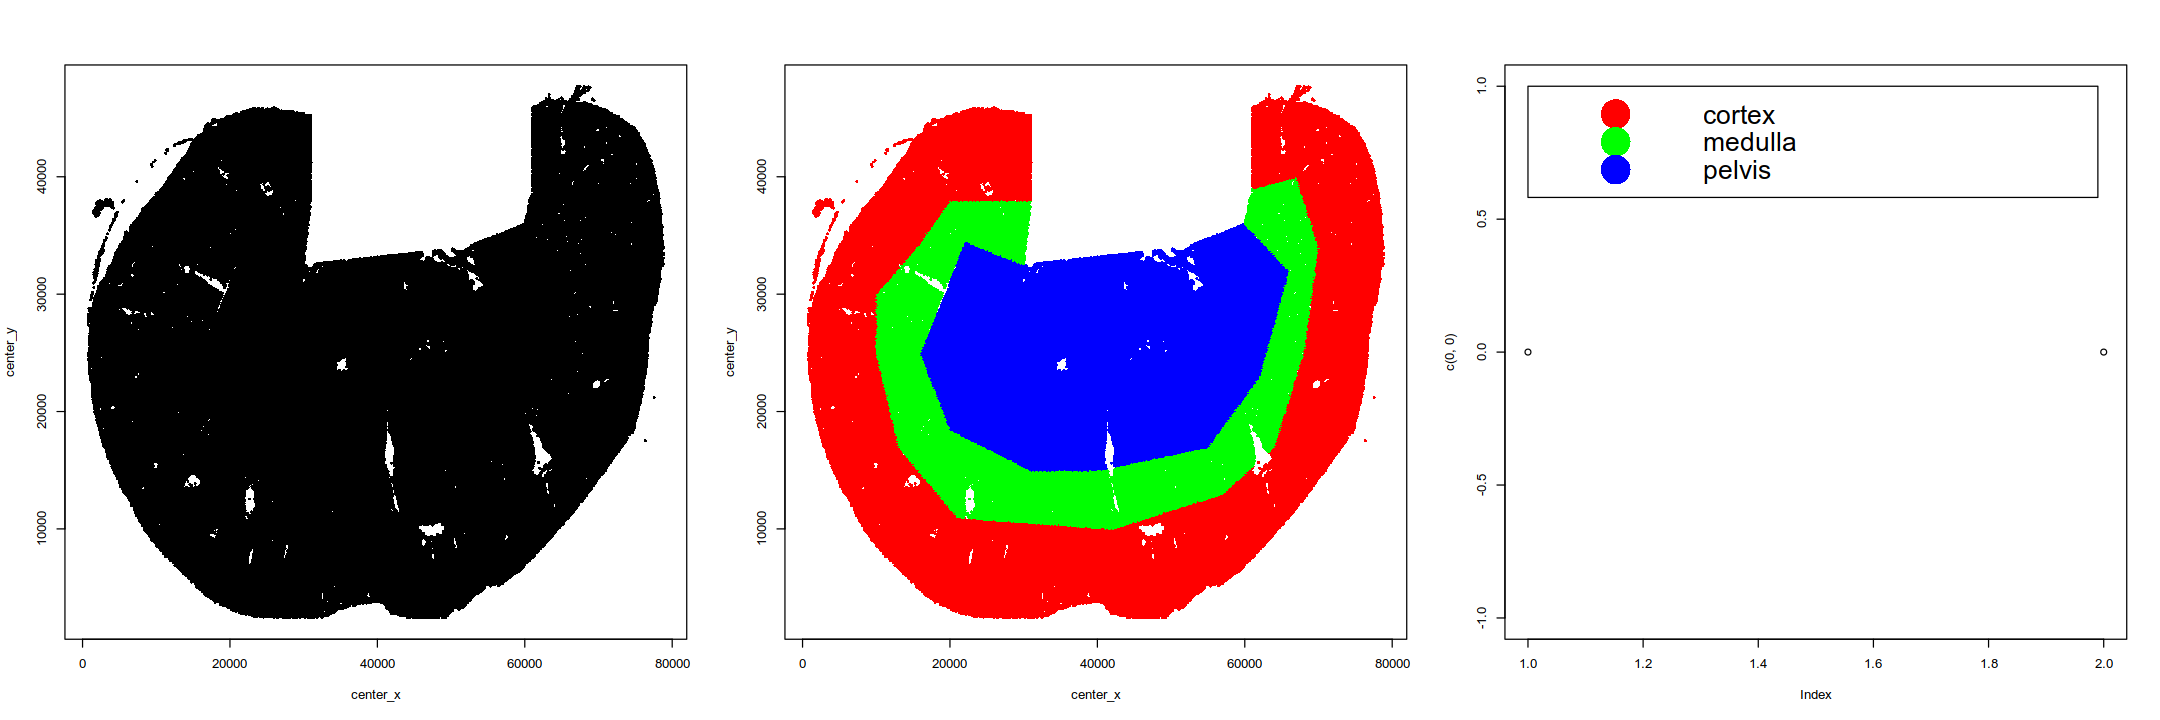

In [8]:
options(repr.plot.width=18, repr.plot.height=6)
par(mfrow = c(1,3))
plot(pos, pch = 16, cex = 0.5)
plot(pos, pch = 16, cex = 0.5, col = col.region)
plot(c(0,0))
legend(x = 1, y = 1, legend = names(leg.col.region), col = leg.col.region, 
       pch=16, cex = 2, ncol=1, pt.cex = 5)

## NORMALIZE FULL DATA

In [9]:
### transpose counts to match previous analyses
counts <- t(counts)
dim(counts)

[1]    219 252553

### scTransform

In [10]:
## sctranform normalization 
suppressMessages(norm.sct.obj <- sctransform::vst(counts, n_genes = NULL)) #genes as rows, cells as cols 
norm.sct <- norm.sct.obj$y
## set negative counts in norm.sct to 0 
norm.sct[norm.sct<0] <- 0

  |======================================================================| 100%
  |======================================================================| 100%


### scaling factors

In [11]:
sf.libsize <- colSums(counts) / median(colSums(counts), na.rm = T)
sf.DESeq <- DESeq2::estimateSizeFactorsForMatrix(as.matrix(counts), type = 'poscounts')
sf.TMMwsp <- edgeR::calcNormFactors(counts, method = 'TMMwsp')  ## multiplied not divided
sf.area <- meta[colnames(counts), 'area'] / median(meta[colnames(counts), 'area'], na.rm = T)
names(sf.area) <- colnames(counts)

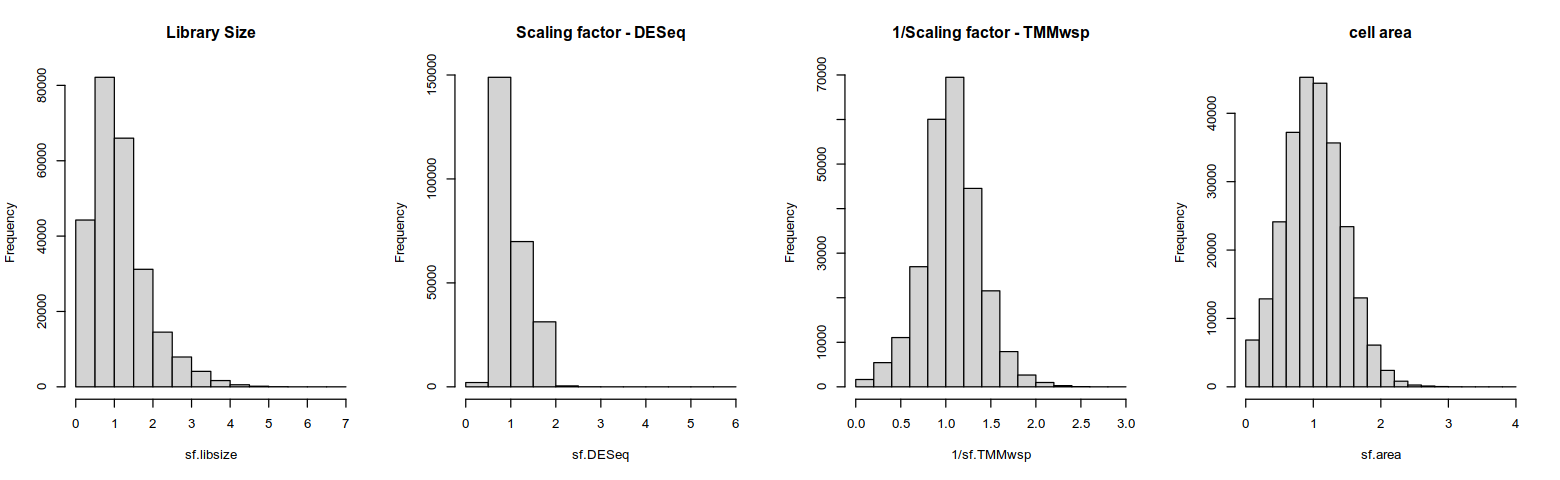

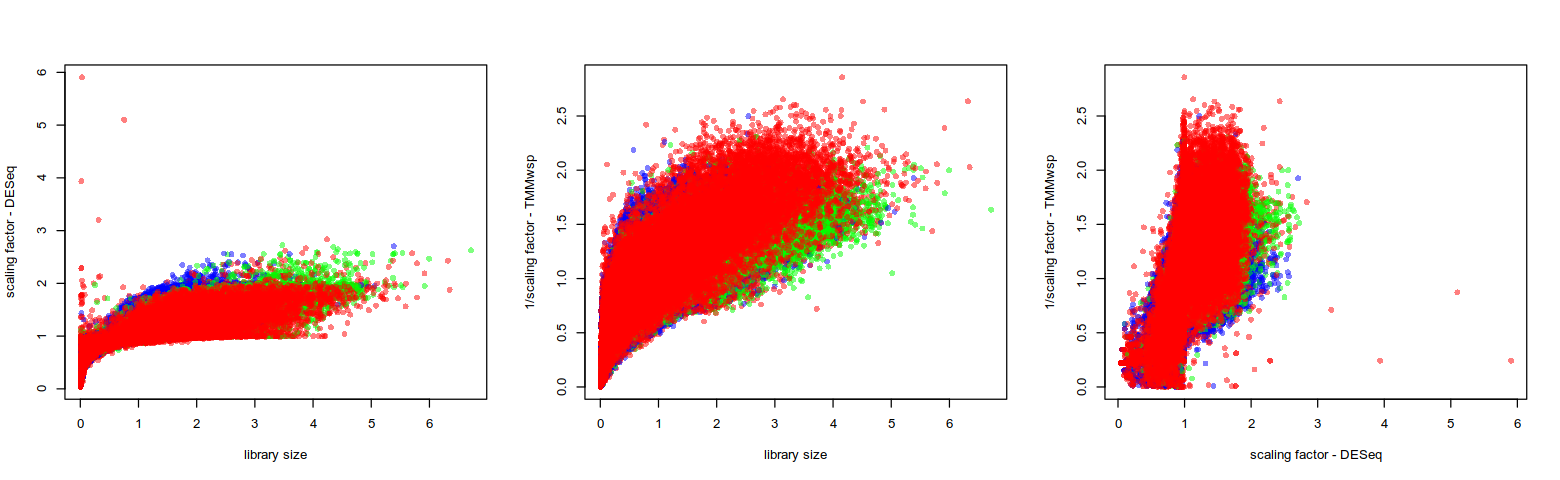

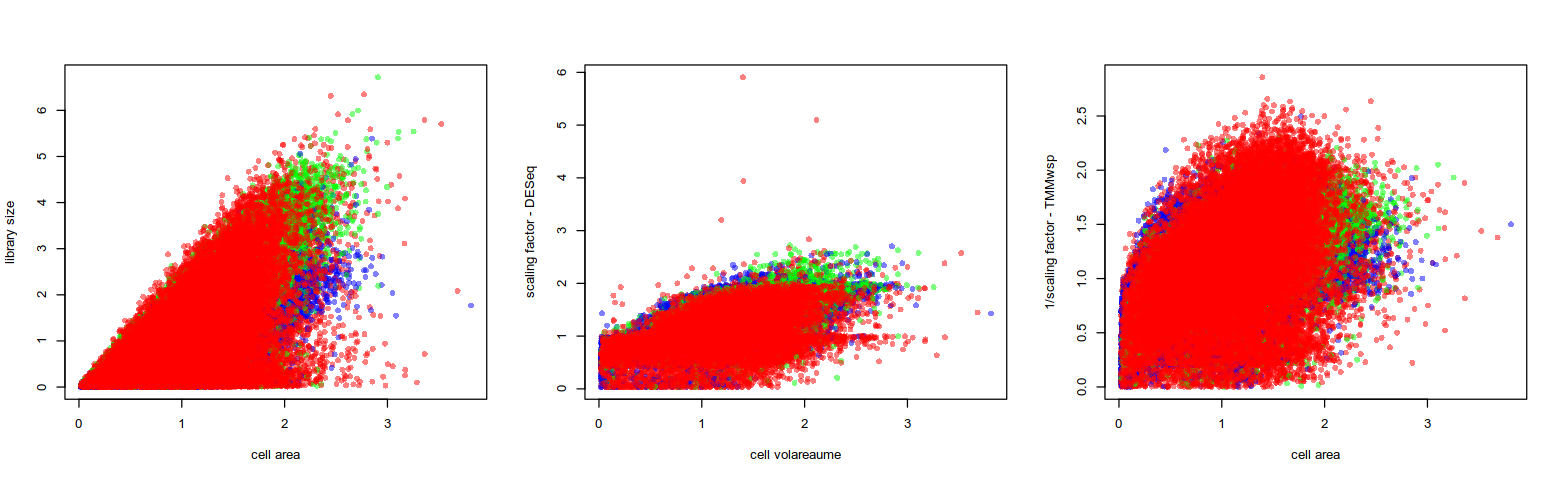

In [12]:
options(repr.plot.width=13, repr.plot.height=4)

par(mfrow = c(1,4))
hist(sf.libsize, main = 'Library Size')
hist(sf.DESeq, main = 'Scaling factor - DESeq')
hist(1/sf.TMMwsp, main = '1/Scaling factor - TMMwsp')
hist(sf.area, main = 'cell area')

par(mfrow = c(1,3))
s <- 1
plot(sf.libsize, sf.DESeq, pch = 16, cex = s, col = scales::alpha(col.region[names(sf.libsize)], 0.5), 
     xlab = 'library size', ylab = 'scaling factor - DESeq')
plot(sf.libsize, 1/sf.TMMwsp, pch = 16, cex = s, col = scales::alpha(col.region[names(sf.libsize)], 0.5), 
     xlab = 'library size', ylab = '1/scaling factor - TMMwsp')
plot(sf.DESeq, 1/sf.TMMwsp, pch = 16, cex = s, col = scales::alpha(col.region[names(sf.libsize)], 0.5), 
     xlab = 'scaling factor - DESeq', ylab = '1/scaling factor - TMMwsp')

plot(sf.area, sf.libsize, pch = 16, cex = s, col = scales::alpha(col.region[names(sf.libsize)], 0.5), 
     xlab = 'cell area', ylab = 'library size')
plot(sf.area, sf.DESeq, pch = 16, cex = s, col = scales::alpha(col.region[names(sf.libsize)], 0.5), 
     xlab = 'cell volareaume', ylab = 'scaling factor - DESeq')
plot(sf.area, 1/sf.TMMwsp, pch = 16, cex = s, col = scales::alpha(col.region[names(sf.libsize)], 0.5), 
     xlab = 'cell area', ylab = '1/scaling factor - TMMwsp')

scaling factors are fairly correlated (except for TMM) - still some region specific effects. 
                                       
look to see if there are region specific (and in turn cell type specific) library size effects 

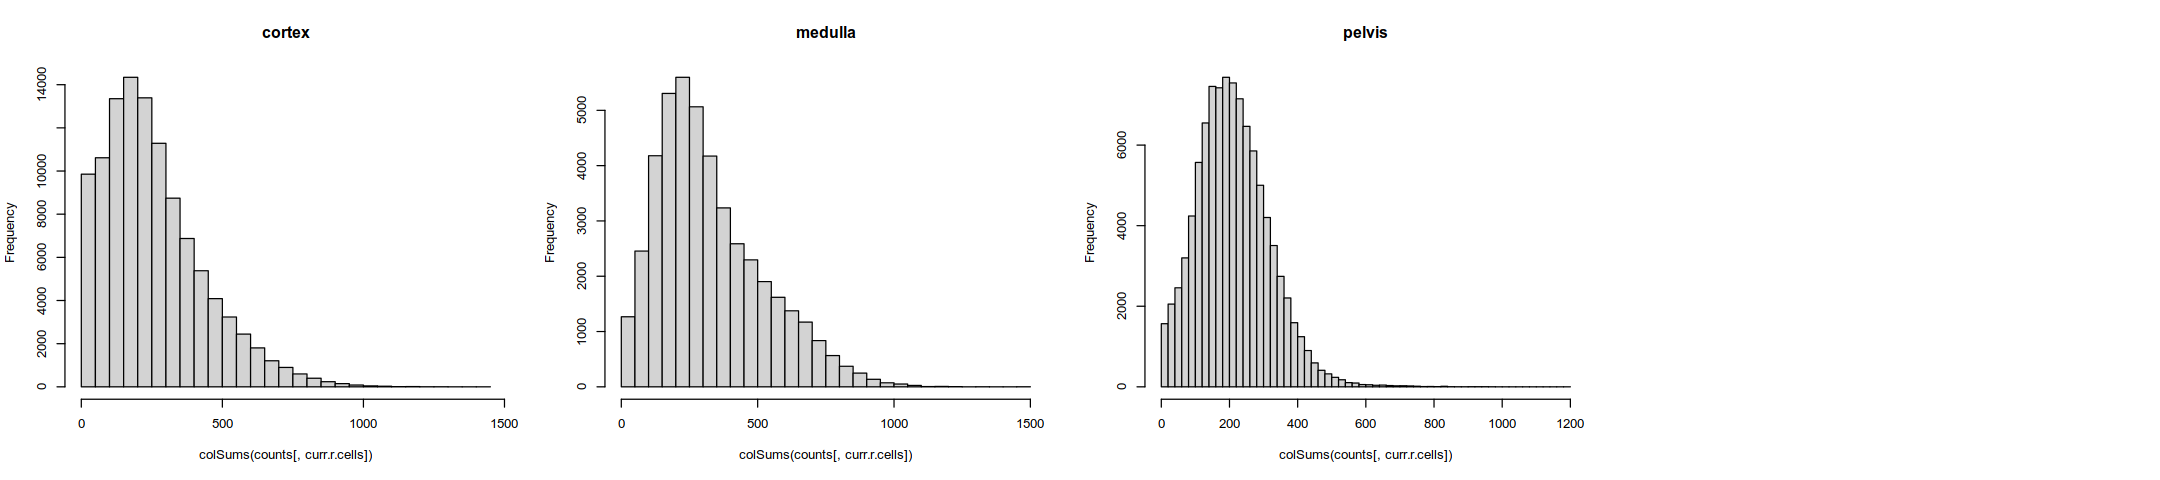

In [13]:
options(repr.plot.width=18, repr.plot.height=4)

par(mfrow = c(1,4))

regions.unq <- unique(meta$region)
for (r in regions.unq){
    curr.r.cells <- rownames(meta[meta$region == r ,])
    hist(colSums(counts[,curr.r.cells]), breaks = 50, main = r)
}


eh not a huge difference

### normalization

In [14]:
norm.none <- counts
norm.deseq <- t(t(counts)/sf.DESeq)
norm.tmm <- t(t(counts)*sf.TMMwsp)
norm.libsize <- t(t(counts)/sf.libsize)
norm.area <- t(t(counts)/sf.area)
all.norms <- list(nonorm = norm.none,
                 libsize = norm.libsize,
                 deseq = norm.deseq,
                 tmm = norm.tmm,
                 area = norm.area,
                 sct = norm.sct)


In [15]:
norms <- names(all.norms)
norms

[1] "nonorm"  "libsize" "deseq"   "tmm"     "area"    "sct"

## DE FULL DATA

In [16]:
cluster <- meta$region
names(cluster) <- rownames(meta)
table(cluster)

cluster
 cortex medulla  pelvis 
 109084   44554   98915 

In [17]:
## get log fold changes and z-scores 
lfcs.all <- lapply(all.norms, function(counts.norm) {
    curr.cluster <- cluster[colnames(counts.norm)]
    names(curr.cluster) <- colnames(counts.norm)
    curr.lfcs <- find.log.fold.change(counts.norm, curr.cluster, log2)
    
    curr.lfcs
})



p.vals.all <- lapply(all.norms, function(counts.norm) {
    curr.cluster <- cluster[colnames(counts.norm)]
    names(curr.cluster) <- colnames(counts.norm)
    curr.pvals <- find.cluster.de.genes(counts.norm, cell.com = curr.cluster, test.alt = 'greater')
    curr.pvals
})

In [18]:
## pick DE genes based on pval threshold 
p.vals.all.adj <- lapply(p.vals.all, function(curr.pvals) {
    curr.pvals.adj <- matrix(p.adjust(curr.pvals, method = 'BH'), 
                             nrow = nrow (curr.pvals), ncol = ncol(curr.pvals))
    colnames(curr.pvals.adj) <- colnames(curr.pvals)
    rownames(curr.pvals.adj) <- rownames(curr.pvals)
    curr.pvals.adj
})


p.thresh <- 0.05
lfc.thresh <- 0.25
de.genes <- lapply(norms, function(curr.norm) {
    curr.pvals <- p.vals.all.adj[[curr.norm]]
    curr.lfcs <- lfcs.all[[curr.norm]]
    
    curr.groups <- colnames(curr.pvals)
    
    curr.de.genes <- lapply(curr.groups, function(curr.group) {
        curr.group.pvals <- curr.pvals[,curr.group]
        curr.group.lfcs <- curr.lfcs[names(curr.group.pvals),curr.group]
        curr.group.de.genes <- names(curr.group.pvals)[curr.group.pvals<p.thresh & abs(curr.group.lfcs)>lfc.thresh]
        curr.group.de.genes.stats <- cbind(curr.group.pvals[curr.group.de.genes], curr.group.lfcs[curr.group.de.genes])
        colnames(curr.group.de.genes.stats) <- c('p.adj','logFC')
        curr.group.de.genes.stats
    })
    names(curr.de.genes) <- curr.groups
    curr.de.genes
})
names(de.genes) <- norms

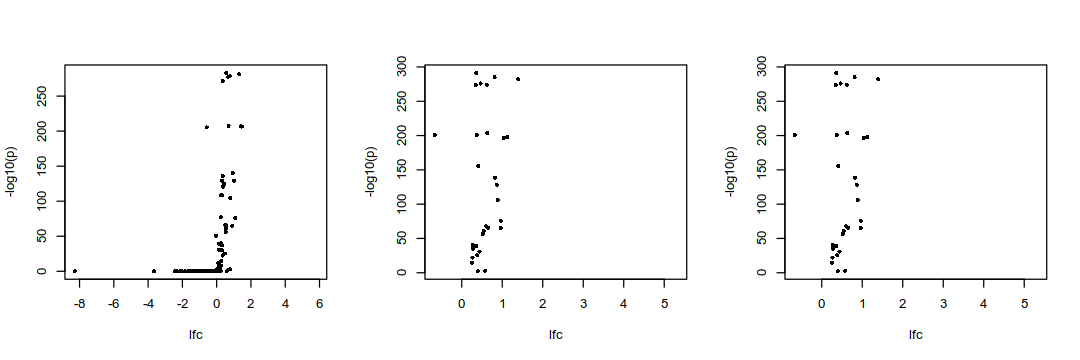

In [19]:
options(repr.plot.width=9, repr.plot.height=3)
par(mfrow = c(1,3))
plot(lfcs.all$sct[,'cortex'], -1*log10(p.vals.all.adj$sct[,'cortex']), 
     pch = 16, cex = 0.7, xlab = 'lfc', ylab = '-log10(p)')

foo <- rownames(de.genes$nonorm$cortex)
plot(lfcs.all$nonorm[foo,'cortex'], -1*log10(p.vals.all.adj$nonorm[foo,'cortex']), 
     pch = 16, cex = 0.7, xlab = 'lfc', ylab = '-log10(p)')

plot(de.genes$nonorm$cortex[,'logFC'],-1*log10(de.genes$nonorm$cortex[,'p.adj']), 
     pch = 16, cex = 0.7, xlab = 'lfc', ylab = '-log10(p)')



[1] 18

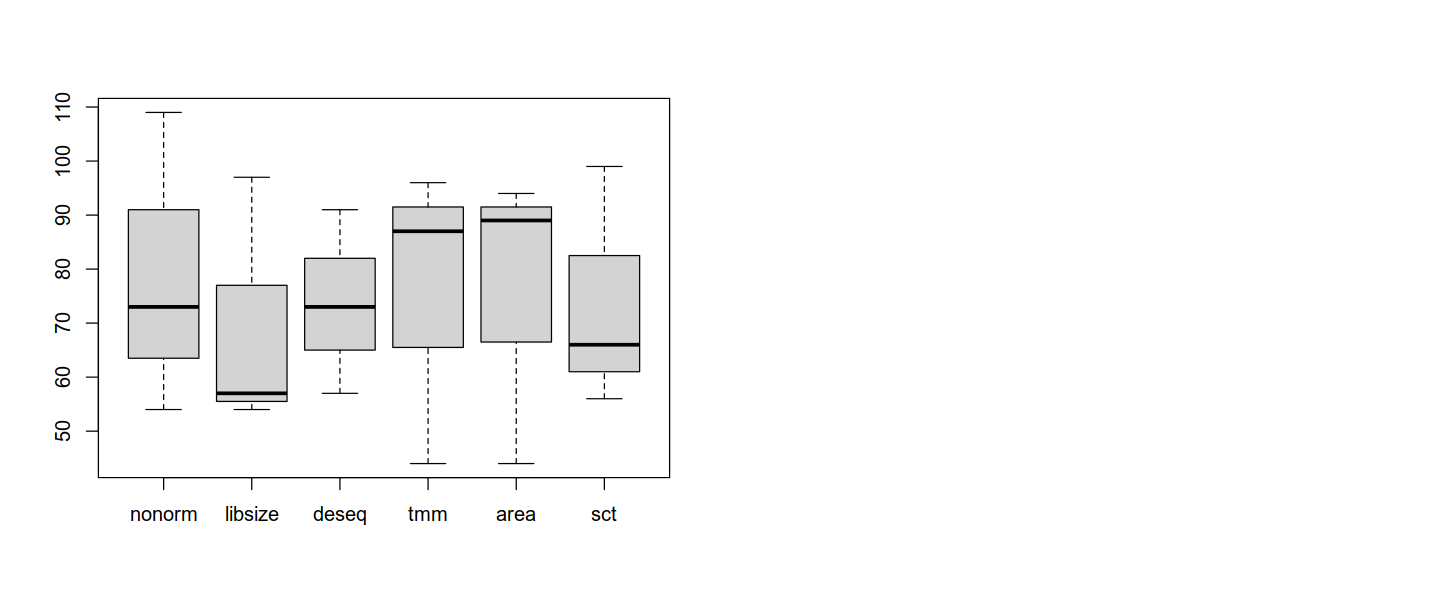

In [20]:
## n DE genes for each cell type per normalization methods
options(repr.plot.width=12, repr.plot.height=5)

n.DEs <- sapply(de.genes, function(x) {
    n.de <- sapply(x, nrow)
    n.de
})

length(n.DEs)
# n.DEs
par(mfrow = c(1,2))
boxplot(n.DEs)

## GENE SUBSETS

In [21]:
regions <- regions.unq ## making compatible with og merfish code 
genes <- rownames(counts)

In [22]:
genesets <- lapply(regions, function(r) {
    Reduce(union, lapply(de.genes, function(curr.norm) {
        rownames(curr.norm[[r]][order(curr.norm[[r]][,'p.adj']),])
    }))
    
})
names(genesets) <- regions

sapply(genesets, function(x) {print(length(x))})


set.seed(0)
n <- 60 ## size of skewed gene panel #50 when doing the small cell subset 
genesets <- lapply(genesets, function(x) sample(x,n))
             
geneset.x <- sample(genes, n)   
genesets[['random']] <- geneset.x
                   
# for (i in seq(5)){
#     for (j in seq(5)){
#         print(paste(names(genesets)[i], names(genesets)[j]))
#         print(length(intersect(genesets[[i]], genesets[[j]])))
#     }
# }
      

[1] 61
[1] 119
[1] 102


cortex medulla  pelvis 
     61     119     102

### heatmap

In [23]:
# get skewed geneset genes (minus random geneset)
hm.genes <- unlist(genesets[1:3])

# find which genes are duplicated 
hm.genes.dups <- unique(hm.genes[duplicated(hm.genes)])
length(hm.genes.dups)

# remove duplicated genes (all instances)
hm.genes <- hm.genes[! hm.genes %in% hm.genes.dups]
length(hm.genes)

# add one instance of duplicate genes back lol - but now they're at the front
hm.genes <- c(hm.genes.dups, hm.genes)
length(hm.genes)

# add non DE genes to the front 
hm.genes.nongs <- rownames(counts)[! rownames(counts) %in% hm.genes]
hm.genes <- c(hm.genes, hm.genes.nongs)
length(hm.genes)

### order should be: [non DE genes][DE genes for more than one region][specific DE genes]
htmp.col <- rev(colorRampPalette(brewer.pal(11, "RdBu"))(100))

[1] 29

[1] 122

[1] 151

[1] 219

In [24]:
# average within tissue region
hoo.gexp <- matrix(0, ncol = length(names(genesets))-1, nrow = nrow(counts))
colnames(hoo.gexp) <- names(genesets)[1:3]
rownames(hoo.gexp) <- rownames(counts)

for (gs in colnames(hoo.gexp)){
    print(gs)
    curr.cells <- rownames(meta[meta$region == gs ,])
    print(length(curr.cells))
    curr.gs.avg.gexp <- rowMeans(counts[,curr.cells])
    hoo.gexp[,gs] <- curr.gs.avg.gexp
}

[1] "cortex"
[1] 109084
[1] "medulla"
[1] 44554
[1] "pelvis"
[1] 98915


In [25]:
gs.names <- c('Cortex', 'Medulla', 'Pelvis', NA)
names(gs.names) <- names(genesets)
gs.order <- c(1,2,3)
gs.names[gs.order]

cortex   medulla    pelvis 
 "Cortex" "Medulla"  "Pelvis"

In [26]:
dir.create(paste0(save.dir,'heatmaps'))

In [27]:
## mean exp full panel heatmap
options(repr.plot.width=7, repr.plot.height=5)
pdf(paste0(save.dir,'heatmaps/heatmap_full.pdf'), width = 7, height = 5)
heatmap(hoo.gexp[hm.genes,gs.order], scale = 'row', col = htmp.col, 
        Colv = NA, Rowv = NA, 
        ColSideColors = leg.col.region.og[colnames(hoo.gexp[,gs.order])],
       labRow = FALSE, labCol = FALSE,
        margins = c(3.8,2.1)
       )
title(ylab=paste('Genes\nFull gene panel'), line=0.5, cex.lab=1)
title(xlab=paste('Cells'), line=4, cex.lab=1)
dev.off()

png 
  2

In [28]:
options(repr.plot.width=7, repr.plot.height=5)
pdf(paste0(save.dir,'heatmaps/heatmap_full_colorbar_div.pdf'), width = 7, height = 5)
gplots::heatmap.2(hoo.gexp[hm.genes,gs.order], scale = 'row', col = htmp.col, 
        Colv = NA, Rowv = NA, 
        ColSideColors = leg.col.region.og[colnames(hoo.gexp[,gs.order])],
       labRow = FALSE, labCol = FALSE,
        margins = c(3.8,2.1),
          trace = 'none',
          keysize = 5, density.info = 'none',
          key.title = NA, key.xlab = 'Gene Z-score'
          
       )
title(ylab=paste('Genes\nFull gene panel'), line=0.5, cex.lab=1)
title(xlab=paste('Cells'), line=4, cex.lab=1)
dev.off()

Warning message in gplots::heatmap.2(hoo.gexp[hm.genes, gs.order], scale = "row", :
“Discrepancy: Rowv is FALSE, while dendrogram is `both'. Omitting row dendogram.”
Warning message in gplots::heatmap.2(hoo.gexp[hm.genes, gs.order], scale = "row", :
“Discrepancy: Colv is FALSE, while dendrogram is `column'. Omitting column dendogram.”


png 
  2

In [29]:
## mean exp skewed gene panel heat map
s <- 'row'

for (gs in names(genesets)){
    foo.genes <- genesets[[gs]]
    hm.genes.gs <- hm.genes[hm.genes %in% foo.genes]
    
    pdf(paste0(save.dir,'heatmaps/heatmap_',gs,'.pdf'), width = 7, height = 5)
    par(mfrow = c(1,1), mar = c(5.1, 4.1, 4.1, 2.1))

    heatmap(hoo.gexp[hm.genes.gs,gs.order], scale = 'row', col = htmp.col, 
            Colv = NA, Rowv = NA, 
            ColSideColors = leg.col.region.og[colnames(hoo.gexp[,gs.order])],
           labRow = FALSE, labCol = FALSE,
#               trace = 'none',
            margins = c(3.8,2.1)
           )
    if (gs == 'random'){
        title(ylab=paste('Genes\nNon-skewed gene panel'), line=0.5, cex.lab=2)
    } else {
        title(ylab=paste0('Genes\n', gs.names[gs], '-skewed gene panel'), line=0.5, cex.lab=2)
    }
    title(xlab=paste('Cells'), line=4, cex.lab=2)
    dev.off()
}


## COUNT SUBSETS

In [30]:
counts.subsets <- lapply(genesets, function(gs) {
    curr.subset.counts <- counts[gs,]
    curr.empty.cells <- colSums(curr.subset.counts)==0
    curr.subset.counts <- curr.subset.counts[,!curr.empty.cells]
    curr.subset.counts
})
names(counts.subsets)
sapply(counts.subsets, dim)

[1] "cortex"  "medulla" "pelvis"  "random"

cortex,medulla,pelvis,random
60,60,60,60
250771,249981,250764,251143


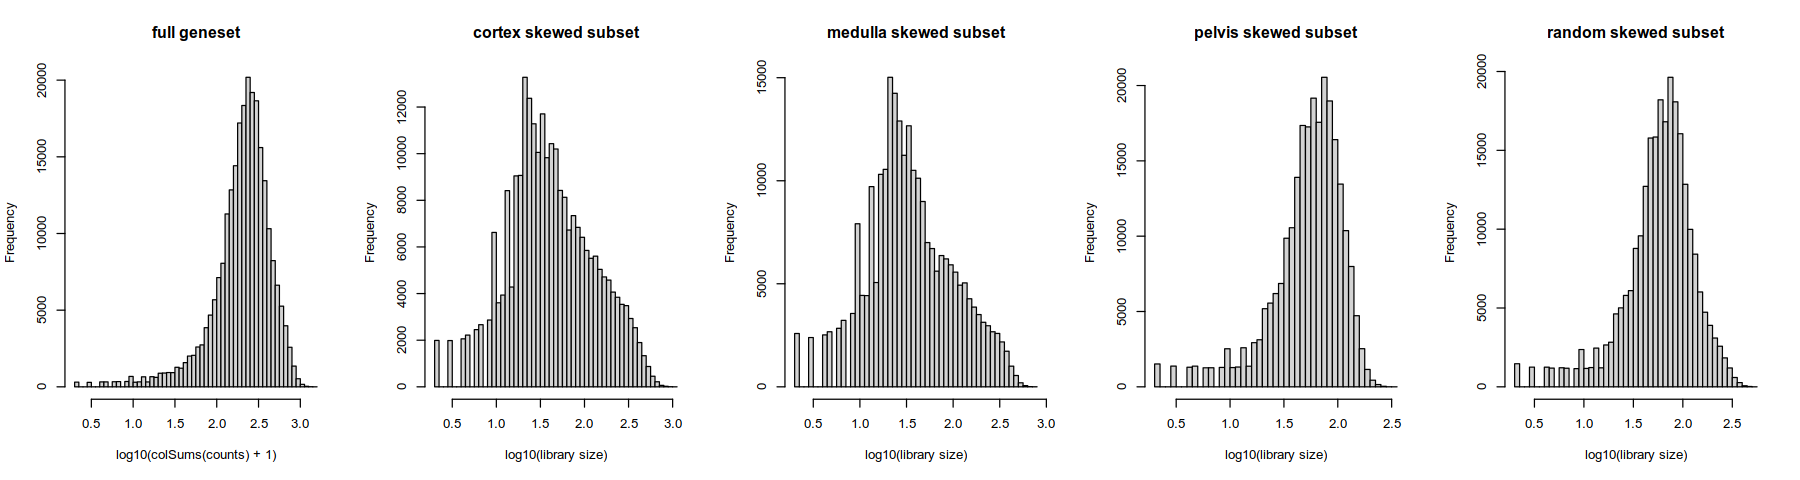

In [31]:
options(repr.plot.width=15, repr.plot.height=4)
par(mfcol = c(1,5))
hist(log10(colSums(counts)+1), breaks = 50, main = 'full geneset')

for (g in names(counts.subsets)){
    x <- counts.subsets[[g]]
    
    hist(log10(colSums(x)+1), breaks = 50, 
         main = paste(g, 'skewed subset'), xlab = 'log10(library size)')
    
}

### scaling factors skewed genesets

In [32]:
skewed.sfs <- lapply(counts.subsets, function(x) {
    curr.libsize <- colSums(x) / median(colSums(x), na.rm = T)
    curr.sf.DESeq <- DESeq2::estimateSizeFactorsForMatrix(as.matrix(x), type = 'poscounts')
    curr.sf.TMMwsp <- edgeR::calcNormFactors(x, method = 'TMMwsp')  ## multiplied not divided
    curr.sf.volume <- meta[colnames(x), 'area'] / median(meta[colnames(x), 'area'], na.rm = T)
    names(curr.sf.volume) <- colnames(x)
    
    list(libsize = curr.libsize,
        deseq = curr.sf.DESeq,
        tmm = curr.sf.TMMwsp,
        area = curr.sf.volume)
})

In [33]:
sf.all <- list(libsize = sf.libsize,
               deseq = sf.DESeq,
               tmm = sf.TMMwsp,
               area = sf.area)

## COMPARE SCALING FACTORS: SKEWED vs OG

In [34]:
dir.create(paste0(save.dir,'scaling_factor_comparison'))

In [35]:
options(repr.plot.width=20, repr.plot.height=8)
set.seed(0)

norms.to.include <- c('libsize', 'deseq', 'tmm', 'area')
norms.names <- c('Library Size', 'DESeq2', 'TMM', 'Cell Area')
names(norms.names) <- norms.to.include

for (g in names(genesets)){
    pdf(paste0(save.dir,'scaling_factor_comparison/',g,'_skewed_vs_all_genes_grouped.pdf'), 
        width = 20, height = 5) #, antialias = 'none')
    par(mfrow = c(1,4), mar = c(10.1, 10.1, 6.1, 2.1)) #mar = c(5.1, 4.1, 4.1, 2.1)
    
    curr.sfs.skewed <- skewed.sfs[[g]][norms.to.include]
    curr.common.cells <- Reduce(intersect, lapply(curr.sfs.skewed, names))
    
    for (n in norms.to.include){
        
        curr.sf.skewed <- curr.sfs.skewed[[n]]
        curr.sf.all <- sf.all[[n]]
        
        curr.x <- log10(curr.sf.all[curr.common.cells]+1)
        curr.x.lim <- range(curr.x)
        
        curr.y <- log10(curr.sf.skewed[curr.common.cells]+1)
        curr.y.lim <- range(curr.y)
        
        #change color to highlight roi for region skewed geneset
        curr.cols <- col.region
        curr.cols[region != g] <- 'grey'
        
        #use all colors for random geneset
        if (g == 'random'){
            curr.cols <- col.region
        }
        
        
        #reorder when all together
        o <- sample(length(curr.x))
        o <- sample(o)
        
        plot(curr.x[o], curr.y[o], #axes = FALSE,
             pch = 16, cex = 1.5, ##point sizes
             col = scales::alpha(curr.cols[curr.common.cells[o]], 0.25), ##point colors
             cex.axis = fs, cex.main = fs, ##font sizes
             xaxt="n", yaxt="n", bty = 'n', xaxs = 'i', yaxs = 'i', ##axis settings
             xlim = curr.x.lim, ylim = curr.y.lim, xlab = '', ylab = '',  ##axis ranges and labels
             main = paste(norms.names[n])) ##title 
        
        ## axis labels
        title(xlab=paste('Full gene panel'), line=8, cex.lab=4)
        title(ylab=paste('Skewed gene panel'), line=5, cex.lab=4)       
        
        ## axis tick mark formats
        axis(side = 1, at = curr.x.lim, line = 0, cex.axis = fs, lty = 1, labels = FALSE)
        axis(side = 2, at = curr.y.lim, line = 0, cex.axis = fs, lty = 1, labels = FALSE)
        axis(side = 1, line = 0, cex.axis = fs.small, lty = 1, labels = FALSE)
        axis(side = 2, line = 0, cex.axis = fs.small, lty = 1, labels = FALSE)
        axis(side = 1, line = 2.5, cex.axis = fs.small, lty = 0)
        axis(side = 2, line = 0.5, cex.axis = fs.small, lty = 0)
        abline(a=0,b=1,col='red')

    }
    dev.off()

}


### RMSE scaling factors

In [36]:
rmse.sf <- lapply(names(skewed.sfs), function(reg) {
    gs <- skewed.sfs[[reg]]
    
    curr.gs.rmse <- sapply(names(gs), function(n) {
        curr.skewed.sf <- gs[[n]]
        curr.full.sf <- sf.all[[n]]
        
        curr.cells <- intersect(names(curr.skewed.sf), names(curr.full.sf))
        
        curr.skewed.sf <- curr.skewed.sf[curr.cells]
        curr.full.sf <- curr.full.sf[curr.cells]
        
        all <- rmse(curr.skewed.sf, curr.full.sf)
        if (reg != 'random'){
            curr.reg.cells <- intersect(names(curr.skewed.sf), names(cluster[cluster==reg]))
            curr.reg <- rmse(curr.skewed.sf[curr.reg.cells], curr.full.sf[curr.reg.cells])
            
            curr.other.regs <- names(skewed.sfs)[names(skewed.sfs) != reg]
            
            curr.other.cells <- intersect(names(curr.skewed.sf), names(cluster[cluster %in% curr.other.regs]))
            curr.other <- rmse(curr.skewed.sf[curr.other.cells], curr.full.sf[curr.other.cells])   
        } else {
            curr.reg = NA
            curr.other = NA
        }
        
        list(all = all,
            reg = curr.reg,
            other = curr.other)        
        
    })
    names(curr.gs.rmse) <- names(gs)
    curr.gs.rmse
})

names(rmse.sf) <- names(skewed.sfs)

rmse.sfs.all <- (sapply(rmse.sf, function(gs) {
    unlist(gs['all',])
}))

rmse.sfs.reg <- (sapply(rmse.sf, function(gs) {
    unlist(gs['reg',])
}))

rmse.sfs.other <- (sapply(rmse.sf, function(gs) {
    unlist(gs['other',])
}))

In [37]:
rmse.sfs.all

,cortex,medulla,pelvis,random
libsize,2.312578016,2.212819350,0.6930546535,0.4070991713
deseq,0.621047063,0.316808755,0.2547463571,0.2404139565
tmm,11.669164521,7.104878330,5.1483010369,6.4158714747
area,0.002344002,0.002500358,0.0009376778,0.0009376854


In [38]:
dir.create(paste0(save.dir,'sf_rmse'))

In [39]:
col.geneset <- leg.col.region
names(col.geneset)[names(col.geneset)=='other'] <- 'random'
col.geneset['random'] <- 'grey'
geneset.names <- gs.names
geneset.names['random'] <- 'Random'

In [40]:
options(repr.plot.width=6, repr.plot.height=7)
pdf(paste0(save.dir, 'sf_rmse/scaling_factor_RMSE_all_genesets.pdf'),  
    width = 7, height = 8)
par(mfrow = c(1,1), mar = c(17.1, 10, 3.1, 2.1))
## all 
norms.to.include
xtcks <- c(0:length(norms.to.include)+1)

x <- rep(seq(length(norms.to.include)), each = length(genesets)) # no sctransform sf or no norm sfs
y <- as.vector(t(rmse.sfs.all))
xl <- c(0,max(x)+1)
yl <- c(0,max(y)+1)

curr.col <- rep(col.geneset[colnames(rmse.sfs.all)], length(norms.to.include))
curr.pch <- rep(c(15:18), length(norms.to.include))

plot(x,y, pch = curr.pch, cex = 4, col = scales::alpha(curr.col, 0.7), xlim = xl, ylim = yl, 
     bg = scales::alpha(col.geneset['random'], 0.7),
    xaxt = "n", yaxt = "n", frame.plot=FALSE, xaxs = 'i', yaxs = 'i',
    ylab = '', xlab = '')
axis(1, at = c(0,xtcks), cex.axis=2, labels = FALSE)
axis(2, at = c(0,seq(ceiling(max(y)))), cex.axis=3, las = 2)
text(x = xtcks[1:length(norms.to.include)]+0.15, y = min(yl)-1, 
     labels = norms.names, xpd = NA, srt = 45, cex = 2, pos = 2)
title(xlab='Normalization', line=14, cex.lab=fs)
title(ylab='RMSE', line=6, cex.lab=fs)
dev.off()

pdf(paste0(save.dir, 'geneset_legend.pdf'),  
    width = 7, height = 8)
plot(0,0, col = 'white')
legend('topleft', legend = geneset.names, col = scales::alpha(col.geneset[names(geneset.names)],0.7), 
       pch = curr.pch, pt.bg = scales::alpha(col.geneset['random'], 0.7), cex = 2, pt.cex = 4, bty = 'n')
dev.off()

pdf(paste0(save.dir, 'sf_rmse/scaling_factor_RMSE_no_random.pdf'),  
    width = 7, height = 8)
par(mfrow = c(1,1), mar = c(17.1, 10, 3.1, 2.1))
## all minus random 
x = rep(seq(length(norms)-2), each = length(genesets)-1) # no sctransform sf or no norm sfs
y = as.vector(t(rmse.sfs.all[,1:3]))
xl <- c(0,max(x)+1)
yl <- c(0,max(y)+1)

curr.col <- rep(col.geneset[colnames(rmse.sfs.all)[1:3]], length(norms.to.include)-1)
curr.pch <- rep(c(15:17), length(norms.to.include))

plot(x,y, pch = curr.pch, cex = 4, col = scales::alpha(curr.col, 0.7), xlim = xl, ylim = yl,
    xaxt = "n", yaxt = "n", frame.plot=FALSE, xaxs = 'i', yaxs = 'i',
    ylab = '', xlab = '')
axis(1, at = c(0,xtcks), cex.axis=2, labels = FALSE)
axis(2, at = c(0,seq(ceiling(max(y)))), cex.axis=3, las = 2)
text(x = xtcks[1:length(norms.to.include)]+0.15, y = min(yl)-1, 
     labels = norms.names, xpd = NA, srt = 45, cex = 2, pos = 2)
title(xlab='Normalization', line=14, cex.lab=fs)
title(ylab='RMSE', line=6, cex.lab=fs)
dev.off()

[1] "libsize" "deseq"   "tmm"     "area"

png 
  2

png 
  2

png 
  2

In [41]:
norms.to.include
rmse.sfs.all

[1] "libsize" "deseq"   "tmm"     "area"

,cortex,medulla,pelvis,random
libsize,2.312578016,2.212819350,0.6930546535,0.4070991713
deseq,0.621047063,0.316808755,0.2547463571,0.2404139565
tmm,11.669164521,7.104878330,5.1483010369,6.4158714747
area,0.002344002,0.002500358,0.0009376778,0.0009376854


In [42]:
options(repr.plot.width=6, repr.plot.height=7)
pdf(paste0(save.dir, 'sf_rmse/scaling_factor_RMSE_all_genesets_noTMM.pdf'),  
    width = 7, height = 8)
par(mfrow = c(1,1), mar = c(17.1, 10, 3.1, 2.1))
## all 
norms.to.include.noTMM <- norms.to.include[c(1,2,4)]
xtcks <- c(0:length(norms.to.include.noTMM)+1)

x <- rep(seq(length(norms.to.include.noTMM)), each = length(genesets)) # no sctransform sf or no norm sfs
y <- as.vector(t(rmse.sfs.all[norms.to.include.noTMM,]))
xl <- c(0,max(x)+1)
yl <- c(0,max(y)+1)

curr.col <- rep(col.geneset[colnames(rmse.sfs.all)], length(norms.to.include.noTMM))
curr.pch <- rep(c(15:18), length(norms.to.include.noTMM))

plot(x,y, pch = curr.pch, cex = 4, col = scales::alpha(curr.col, 0.7), xlim = xl, ylim = yl, 
     bg = scales::alpha(col.geneset['random'], 0.7),
    xaxt = "n", yaxt = "n", frame.plot=FALSE, xaxs = 'i', yaxs = 'i',
    ylab = '', xlab = '')
axis(1, at = c(0,xtcks), cex.axis=2, labels = FALSE)
axis(2, at = c(0,seq(ceiling(max(y)))), cex.axis=3, las = 2)
text(x = xtcks[1:length(norms.to.include.noTMM)]+0.15, y = min(yl)-1, 
     labels = norms.names, xpd = NA, srt = 45, cex = 2, pos = 2)
title(xlab='Normalization', line=14, cex.lab=fs)
title(ylab='RMSE', line=6, cex.lab=fs)
dev.off()

pdf(paste0(save.dir, 'geneset_legend.pdf'),  
    width = 7, height = 8)
plot(0,0, col = 'white')
legend('topleft', legend = geneset.names, col = scales::alpha(col.geneset[names(geneset.names)],0.7), 
       pch = curr.pch, pt.bg = scales::alpha(col.geneset['random'], 0.7), cex = 2, pt.cex = 4, bty = 'n')
dev.off()

pdf(paste0(save.dir, 'sf_rmse/scaling_factor_RMSE_noTMM_no_random.pdf'),  
    width = 7, height = 8)
par(mfrow = c(1,1), mar = c(17.1, 10, 3.1, 2.1))
## all minus random 
x = rep(seq(length(norms.to.include.noTMM)), each = length(genesets)-1) # no sctransform sf or no norm sfs
y = as.vector(t(rmse.sfs.all[norms.to.include.noTMM,1:3]))
xl <- c(0,max(x)+1)
yl <- c(0,max(y)+1)

curr.col <- rep(col.geneset[colnames(rmse.sfs.all)[1:3]], length(norms.to.include.noTMM)-1)
curr.pch <- rep(c(15:17), length(norms.to.include.noTMM))

plot(x,y, pch = curr.pch, cex = 4, col = scales::alpha(curr.col, 0.7), xlim = xl, ylim = yl,
    xaxt = "n", yaxt = "n", frame.plot=FALSE, xaxs = 'i', yaxs = 'i',
    ylab = '', xlab = '')
axis(1, at = c(0,xtcks), cex.axis=2, labels = FALSE)
axis(2, at = c(0,seq(ceiling(max(y)))), cex.axis=3, las = 2)
text(x = xtcks[1:length(norms.to.include.noTMM)]+0.15, y = min(yl)-1, 
     labels = norms.names, xpd = NA, srt = 45, cex = 2, pos = 2)
title(xlab='Normalization', line=14, cex.lab=fs)
title(ylab='RMSE', line=6, cex.lab=fs)
dev.off()

png 
  2

png 
  2

png 
  2

In [43]:
# options(repr.plot.width=15, repr.plot.height=10)
# pdf(paste0(save.dir, 'rmse/','scaling_factors_all.pdf'),  
#         width = 10, height = 12)
# # pdf(paste0(save.dir, 'rmse/','scaling_factors_noTMM.pdf'),  
# #         width = 10, height = 12)
# par(mfrow = c(3,2))
# ns <- c(1,2,3,4)
# boxplot(rmse.sfs.all[ns,], main = 'all sf rmse')
# boxplot(t(rmse.sfs.all[ns,]))
# boxplot(rmse.sfs.reg[ns,], main = 'sf rmse for skewed region')
# boxplot(t(rmse.sfs.reg[ns,]))
# boxplot(rmse.sfs.other[ns,], main = 'sf rmse for other regions')
# boxplot(t(rmse.sfs.other[ns,]))
# dev.off()

## NORMALIZE SKEWED GENESETS

In [44]:
skewed.norms <- lapply(names(counts.subsets), function(gs) {
    curr.counts <- counts.subsets[[gs]]
    print(head(rownames(curr.counts)))
    curr.sfs <- skewed.sfs[[gs]]
    
    curr.norm.none <- curr.counts
    curr.norm.libsize <- t(t(curr.counts)/curr.sfs[['libsize']]) 
    curr.norm.deseq <- t(t(curr.counts)/curr.sfs[['deseq']])
    curr.norm.tmm <- t(t(curr.counts)*curr.sfs[['tmm']])
    curr.norm.area <- t(t(curr.counts)/curr.sfs[['area']]) 
    
    suppressMessages(curr.sct <- sctransform::vst(curr.counts, n_genes = NULL))
    curr.norm.sct <- curr.sct$y
    curr.norm.sct[curr.norm.sct<0] <- 0
    
    curr.norms <- list(nonorm = curr.norm.none,
                       libsize = curr.norm.libsize,
                       deseq = curr.norm.deseq,
                       tmm = curr.norm.tmm,
                       area = curr.norm.area,
                       sct = curr.norm.sct)
    
    curr.norms
})
names(skewed.norms) <- names(counts.subsets)


[1] "Ptprc"   "Pidd1"   "Ms4a15"  "Col27a1" "Klhl1"   "Cd300ld"
  |======================================================================| 100%
  |======================================================================| 100%
[1] "Sox17"  "Prdm6"  "Cwc25"  "Nceh1"  "C87436" "Angel2"
  |======================================================================| 100%
  |======================================================================| 100%
[1] "Erbin"    "Rad9a"    "Grk1"     "Plpp1"    "Pram1"    "Colgalt1"
  |======================================================================| 100%
  |======================================================================| 100%
[1] "Rpn1"   "Fbln5"  "Mroh8"  "Ephx2"  "Tpm2"   "Trim26"
  |======================================================================| 100%
  |======================================================================| 100%


## COUNT CORRELATIONS

In [45]:
gene.count.corrs <- lapply(names(genesets), function(gs) {
    curr.geneset.corrs <- sapply(norms, function(n) {
        curr.skewed.norm <- skewed.norms[[gs]][[n]]
        curr.all.norm <- all.norms[[n]]
        
        curr.cells <- intersect(colnames(curr.skewed.norm), colnames(curr.all.norm))
        curr.genes <- intersect(rownames(curr.skewed.norm), rownames(curr.all.norm))
        
        curr.skewed.norm <- curr.skewed.norm[curr.genes, curr.cells]
        curr.all.norm <- curr.all.norm[curr.genes, curr.cells]
        
        curr.corrs <- sapply(curr.genes, function(g) {
            cor(curr.skewed.norm[g,], curr.all.norm[g,], method = 'pearson')
        })
    })
#     names(curr.geneset.corrs) <- norms
    curr.geneset.corrs
})
names(gene.count.corrs) <- names(genesets)



In [46]:
options(repr.plot.width=18, repr.plot.height=5)

norms.to.include <- c('libsize', 'sct', 'deseq', 'tmm', 'area', 'nonorm')
norms.names <- c('Library Size', 'scTransform', 'DESeq2', 'TMM', 'Cell Area', 'No Normalization')
names(norms.names) <- norms.to.include
xtcks <- c(0:length(norms.to.include)+1)

yl <- c(min(sapply(gene.count.corrs, function(x) {min(x, na.rm = T)})), 1)
ylr <- c(0.5, 1) #c(min(gene.count.corrs[['random']]), 1)
# yl <- c(0,1)

for (gs in names(genesets)){
    pdf(paste0(save.dir, 'single_cell_single_gene_count_correlation_',gs,'.pdf'),  
        width = 10, height = 12)
#     par(mfrow = c(1,1), mar = c(20.1, 9, 3.1, 2.1)) #not ventricles
    par(mfrow = c(1,1), mar = c(17.1, 10, 3.1, 2.1))
    
    curr.corrs <- gene.count.corrs[[gs]]
    
    boxplot(curr.corrs[,norms.to.include], ylim = yl, #ylim = ylr, #ylim = yl,
            cex.lab = fs.small, cex.axis = fs.small, cex.main = fs, xaxs = 'i', yaxs = 'i',
            xaxt = "n", yaxt = "n", frame.plot=FALSE,
            ylab = '',# xlab = 'Normalization',
#             main = paste('Normalized gene count correlation:\n',gs, 'skewed vs full geneset')
           )
    axis(1, at = c(0,xtcks), cex.axis=2, labels = FALSE) #x axis ticks
    text(x = xtcks[1:length(norms.to.include)]+0.15, y = min(yl)-0.02, labels = norms.names, xpd = NA, srt = 45, cex = 2, pos = 2) ##ventricles/random
#     text(x = c(1:5)+0.15, y = 0.47, labels = norms.names, xpd = NA, srt = 45, cex = 3, pos = 2) ##ventricles
#     text(x = c(1:5)+0.15, y = 0, labels = norms.names, xpd = NA, srt = 45, cex = 3, pos = 2) #not ventricles
#     axis(2, at = c(0.4,0.6,0.8,1), cex.axis=2, las = 2) ##ventricles/random
    axis(2, at = c(0,0.2,0.4,0.6,0.8,1), cex.axis=3, las = 2)
#     title(xlab='Normalization', line=19, cex.lab=fs) #not ventricles
    title(xlab='Normalization', line=14, cex.lab=fs)
#     title(ylab='Pearson Correlation', line=5, cex.lab=fs) #not ventricles
    title(ylab='Pearson Correlation', line=6, cex.lab=fs)
#     title(ylab=paste('Skewed gene panel\n log_10(scaling factor)'), line=4, cex.lab=3)
    
    dev.off()
}




## DE GENES SKEWED GENESETS

In [47]:
skewed.lfcs <- lapply(skewed.norms, function(curr.skewed.norms) {
    
    curr.skewed.lfcs <- lapply(curr.skewed.norms, function(curr.counts.norm) {
        curr.clusters <- cluster[colnames(curr.counts.norm)]
        names(curr.clusters) <- colnames(curr.counts.norm)
        curr.lfcs <- find.log.fold.change(curr.counts.norm, curr.clusters, log2)
        
        curr.lfcs
    })
    
    curr.skewed.lfcs
    
})

skewed.pvals <- lapply(skewed.norms, function(curr.skewed.norms) {
    
    curr.skewed.pvals <- lapply(curr.skewed.norms, function(curr.counts.norm) {
        curr.clusters <- cluster[colnames(curr.counts.norm)]
        names(curr.clusters) <- colnames(curr.counts.norm)
        curr.pvals <- find.cluster.de.genes(curr.counts.norm, cell.com = curr.clusters, test.alt = 'greater')
        
        curr.pvals
    })
    
    curr.skewed.pvals
    
})

skewed.pvals.adj <- lapply(skewed.pvals, function(curr.geneset.pvals) {
    
    curr.geneset.pvals.adj <- lapply(curr.geneset.pvals, function(curr.pvals) {
        curr.pvals.adj <- matrix(p.adjust(curr.pvals, method = 'BH'), 
                                 nrow = nrow (curr.pvals), ncol = ncol(curr.pvals))
        colnames(curr.pvals.adj) <- colnames(curr.pvals)
        rownames(curr.pvals.adj) <- rownames(curr.pvals)
        
        curr.pvals.adj
    })
    
    
    
})


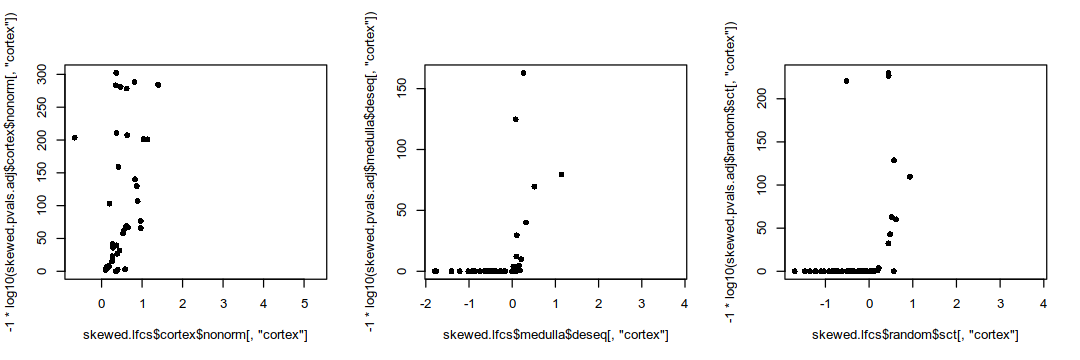

In [48]:
options(repr.plot.width=9, repr.plot.height=3)
par(mfrow = c(1,3))
plot(skewed.lfcs$cortex$nonorm[,'cortex'],
    -1*log10(skewed.pvals.adj$cortex$nonorm[,'cortex']),
    pch = 16)
plot(skewed.lfcs$medulla$deseq[,'cortex'],
    -1*log10(skewed.pvals.adj$medulla$deseq[,'cortex']),
    pch = 16)
plot(skewed.lfcs$random$sct[,'cortex'],
    -1*log10(skewed.pvals.adj$random$sct[,'cortex']),
    pch = 16)

## quantify skew using shannon entropy 

### full gene panel

In [49]:
## max evenness
props <- rep(0.33,3)
-1*sum(props*log(props))

## max skew
props <- c(0.9997,0.0001,0.0001,0.0001)
sum(props)
-1*sum(props*log(props))

## og gene panel - use non normalized counts for now
props <- n.DEs[,'nonorm']/nrow(all.norms$nonorm)
props
full.div <- -1*sum(props*log(props))
full.div

[1] 1.097576

[1] 1

[1] 0.003063057

cortex   medulla    pelvis 
0.2465753 0.4977169 0.3333333

[1] 1.0587

### skewed gene panels

In [50]:
## de genes for skewed genesets 
p.thresh <- 0.05
lfc.thresh <- 0.25

skewed.de.genes <- lapply(names(genesets), function(gs) {
    curr.gs.de.genes <- lapply(norms, function(curr.norm) {
        curr.pvals <- skewed.pvals[[gs]][[curr.norm]]
        curr.lfcs <- skewed.lfcs[[gs]][[curr.norm]]
        
        curr.groups <- colnames(curr.pvals)
        
        curr.de.genes <- lapply(curr.groups, function(curr.group) {
            curr.group.pvals <- curr.pvals[,curr.group]
            curr.group.lfcs <- curr.lfcs[names(curr.group.pvals),curr.group]
            
            curr.group.de.genes <- names(curr.group.pvals)[curr.group.pvals<p.thresh & abs(curr.group.lfcs)>lfc.thresh]
            curr.group.de.genes.stats <- cbind(curr.group.pvals[curr.group.de.genes],
                                               curr.group.lfcs[curr.group.de.genes])
            colnames(curr.group.de.genes.stats) <- c('p.adj','logFC')
            curr.group.de.genes.stats
            
        })
        names(curr.de.genes) <- curr.groups
        curr.de.genes
    })
    names(curr.gs.de.genes) <- norms
    curr.gs.de.genes
})
names(skewed.de.genes) <- names(genesets)

In [51]:
## number of de genes
skewed.n.DEs <- lapply(skewed.de.genes, function(curr.de.genes) {
    curr.n.DEs <- sapply(curr.de.genes, function(x) {
        sapply(x, nrow)
    })
    curr.n.DEs
})


In [52]:
names(skewed.n.DEs)
length(genesets$cortex)

[1] "cortex"  "medulla" "pelvis"  "random"

[1] 60

In [53]:
n.genes <- length(genesets[[1]])
n.genes

skewed.props <- lapply(skewed.n.DEs, function(x) {
    x[,'nonorm']/n.genes
})
skewed.div <- sapply(skewed.props, function(x) {
    -1*sum(x[x>0]*log(x[x>0]))
})

[1] 60

In [54]:
skewed.props
skewed.div


$cortex
   cortex   medulla    pelvis 
0.8833333 0.5333333 0.0000000 

$medulla
   cortex   medulla    pelvis 
0.2500000 0.9000000 0.1166667 

$pelvis
   cortex   medulla    pelvis 
0.0000000 0.3166667 0.6833333 

$random
   cortex   medulla    pelvis 
0.1833333 0.5333333 0.3500000

cortex   medulla    pelvis    random 
0.4448378 0.6920487 0.6243313 1.0137114

In [55]:
dir.create(paste0(save.dir,'panel_div'))

In [56]:
panel.div <- c(skewed.div, full.div)
names(panel.div) <- c(names(skewed.div), 'full')
panel.div.names <- c(gs.names[1:(length(gs.names)-1)], 'Random', 'Original')
options(repr.plot.width=6, repr.plot.height=7)
pdf(paste0(save.dir, 'panel_div/panel_diversity_all_genesets.pdf'),  
    width = 8, height = 9)
par(mfrow = c(1,1), mar = c(17.1, 10, 3.1, 2.1))
xtcks <- c(0:length(panel.div)+1)
x <- seq(length(panel.div))
y <- panel.div
xl <- c(0,max(x)+1)
yl <- c(0,max(y))
sp <- c(1.5, rep(1,length(panel.div)-1))

barplot(y, xlim = xl, ylim = yl, width = 0.5, space = sp,
    xaxt = "n", yaxt = "n", xaxs = 'i', yaxs = 'i',
    ylab = '', xlab = '')
axis(1, at = c(0,xtcks), cex.axis=2, labels = FALSE)
axis(2, at = seq(from = 0, to = ceiling(max(y)), by = 0.25), cex.axis=3, las = 2)
text(x = xtcks[1:length(panel.div.names)]+0.15, y = min(yl)-0.15, 
     labels = panel.div.names, xpd = NA, srt = 45, cex = 2, pos = 2)
title(xlab='Gene panel', line=14, cex.lab=fs)
title(ylab='Gene panel diversity', line=6, cex.lab=fs)
dev.off()

png 
  2

## COMPARE P VALUES: SKEWED vs OG

In [57]:
dir.create(paste0(save.dir,'pval_comparison'))

In [58]:
options(repr.plot.width=20, repr.plot.height=8)

norms.to.include <- c('libsize', 'sct', 'deseq', 'tmm', 'area', 'nonorm')
norms.names <- c('Library Size', 'scTransform', 'DESeq2', 'TMM', 'Cell Area', 'No Normalization')
names(norms.names) <- norms.to.include

for (gs in names(genesets)){
    pdf(paste0(save.dir, 'pval_comparison/', gs, '_skewed_vs_all_genes_log.pdf'),  
        width = 30, height = 5)
    par(mfrow = c(1,6), mar = c(10.1, 10.1, 6.1, 2.1))
    
    curr.x.lim <- range(-1*log10(unlist(p.vals.all.adj)), finite = TRUE)
    curr.y.lim <- range(-1*log10(unlist(skewed.pvals.adj[[gs]])), finite = TRUE)    

    
    for (n in norms.to.include){
#         print(gs)
#         print(n)
        curr.skewed.pvalsAdj <- -1*log10(skewed.pvals.adj[[gs]][[n]])
#         curr.skewed.pvalsAdj <- (skewed.pvals.adj[[gs]][[n]])
        
        curr.geneset <- rownames(curr.skewed.pvalsAdj)
        
        curr.og.pvalsAdj <- -1*log10(p.vals.all.adj[[n]][curr.geneset,])
#         curr.og.pvalsAdj <- (p.vals.all.adj[[n]][curr.geneset,])
        
        #change color to highlight roi for region skewed geneset
        curr.cols <- colnames(curr.skewed.pvalsAdj)
        curr.cols <- leg.col.region[curr.cols]
        curr.cols[names(curr.cols) != gs] <- 'grey'
#         print(curr.cols)
        
        #use all colors for random geneset
        if (gs == 'random'){
            curr.cols <- colnames(curr.skewed.pvalsAdj)
            curr.cols <- leg.col.region[curr.cols]
            
        }
        
        curr.cols <- unlist(lapply(curr.cols, function(x) {rep(x, nrow(curr.skewed.pvalsAdj))}))
        
        plot(as.vector(curr.og.pvalsAdj), as.vector(curr.skewed.pvalsAdj), 
             pch = 16, cex = 1.5, col = scales::alpha(curr.cols, 0.75),
             xlim = curr.x.lim, ylim = curr.y.lim,
             cex.lab = fs.small, cex.axis = fs.small, cex.main = fs, xaxt="n", yaxt="n",
             xlab = '', ylab = '', bty = 'n', xaxs = 'i', yaxs = 'i',
#              xlab = paste('Full gene panel\n -log_10(p-value)'), 
#              ylab = paste('Skewed gene panel\n -log_10(p-value)'), 
             main = paste(norms.names[n]))
#         abline(a=0,b=1,col=scales::alpha('grey', 0.5))
        title(xlab=expression(paste('Full gene panel')), line=8, cex.lab=fs)
        title(ylab=paste('Skewed gene panel'), line=5, cex.lab=fs)
        axis(side = 1, at = curr.x.lim, line = 0, cex.axis = fs, lty = 1, labels = FALSE)
        axis(side = 2, at = curr.y.lim, line = 0, cex.axis = fs, lty = 1, labels = FALSE)        
        axis(side = 1, line = 0, cex.axis = fs.small, lty = 1, labels = FALSE)
        axis(side = 2, line = 0, cex.axis = fs.small, lty = 1, labels = FALSE)
        axis(side = 1, line = 2.5, cex.axis = fs.small, lty = 0)
        axis(side = 2, line = 0.5, cex.axis = fs.small, lty = 0)
#         abline(v=0.05, h=0.05,col='grey')
        abline(a=0,b=1,col='red')
        
        ##highlight examples with ventricle skewed geneset on libsize plot
#         if (gs=='ventricles'){
#             eg.points.x <- sapply(seq_along(test.genes), function(i) {
#                 curr.og.pvalsAdj[test.genes[i], test.regions[i]]})
#             eg.points.y <- sapply(seq_along(test.genes), function(i) {
#                 curr.skewed.pvalsAdj[test.genes[i], test.regions[i]]})

#             test.labels <- sapply(seq_along(test.genes), function(i){
#                 paste(test.genes[i], test.regions[i])
#             })            
            
#             points(eg.points.x, eg.points.y, 
#                   pch = 16, cex = 3, col = 'black')
# #             text(eg.points.x+65, eg.points.y+10, labels = test.labels, cex = fs)
#         }
        
        
    }
    dev.off()
    
    pdf(paste0(save.dir, 'pval_comparison/', gs, '_skewed_vs_all_genes.pdf'),  
        width = 30, height = 5)
    par(mfrow = c(1,6), mar = c(10.1, 10.1, 6.1, 2.1))
    

    
    for (n in norms.to.include){
#         print(gs)
#         print(n)
#         curr.skewed.pvalsAdj <- -1*log10(skewed.pvals.adj[[gs]][[n]])
        curr.skewed.pvalsAdj <- (skewed.pvals.adj[[gs]][[n]])
        
        curr.geneset <- rownames(curr.skewed.pvalsAdj)
        
#         curr.og.pvalsAdj <- -1*log10(p.vals.all.adj[[n]][curr.geneset,])
        curr.og.pvalsAdj <- (p.vals.all.adj[[n]][curr.geneset,])
        
        #change color to highlight roi for region skewed geneset
        curr.cols <- colnames(curr.skewed.pvalsAdj)
        curr.cols <- leg.col.region[curr.cols]
        curr.cols[names(curr.cols) != gs] <- 'grey'
#         print(curr.cols)
        
        #use all colors for random geneset
        if (gs == 'random'){
            curr.cols <- colnames(curr.skewed.pvalsAdj)
            curr.cols <- leg.col.region[curr.cols]
            
        }
        
        curr.cols <- unlist(lapply(curr.cols, function(x) {rep(x, nrow(curr.skewed.pvalsAdj))}))
        
        plot(as.vector(curr.og.pvalsAdj), as.vector(curr.skewed.pvalsAdj), 
             pch = 16, cex = 1.5, col = scales::alpha(curr.cols, 0.75),
             cex.lab = fs.small, cex.axis = fs.small, cex.main = fs, xaxt="n", yaxt="n",
             xlab = '', ylab = '', bty = 'n', xaxs = 'i', yaxs = 'i',
#              xlab = paste('Full gene panel\n -log_10(p-value)'), 
#              ylab = paste('Skewed gene panel\n -log_10(p-value)'), 
             main = paste(norms.names[n]))
#         abline(a=0,b=1,col=scales::alpha('grey', 0.5))
        title(xlab=paste('Full gene panel\n p-value'), line=8, cex.lab=fs)
        title(ylab=paste('Skewed gene panel\n p-value'), line=5, cex.lab=fs)
        axis(side = 1, line = 0, cex.axis = fs.small, lty = 1, labels = FALSE)
        axis(side = 2, line = 0, cex.axis = fs.small, lty = 1, labels = FALSE)
        axis(side = 1, line = 2.5, cex.axis = fs.small, lty = 0)
        axis(side = 2, line = 0.5, cex.axis = fs.small, lty = 0)
        abline(v=0.05, h=0.05,col='grey')
        abline(a=0,b=1,col='red')
        
    }
        
    
    dev.off()
}



### RMSE pvals

In [59]:
rmse.pvals <- lapply(names(skewed.pvals.adj), function(reg) {
    gs <- skewed.pvals.adj[[reg]]
    
    curr.gs.rmse <- sapply(names(gs), function(n) {
        curr.skewed.pvals <- gs[[n]]
        curr.full.pvals <- p.vals.all.adj[[n]]
        
        curr.genes <- intersect(rownames(curr.skewed.pvals), rownames(curr.full.pvals))
        
        curr.skewed.pvals <- curr.skewed.pvals[curr.genes,]
        curr.full.pvals <- curr.full.pvals[curr.genes,]
        
        all <- rmse(as.vector(curr.skewed.pvals), as.vector(curr.full.pvals))
        if (reg != 'random'){
            curr.reg <- rmse(as.vector(curr.skewed.pvals[,reg]), as.vector(curr.full.pvals[,reg]))
            curr.other.regs <- colnames(curr.skewed.pvals) != reg
            curr.other <- rmse(as.vector(curr.skewed.pvals[,curr.other.regs]), as.vector(curr.full.pvals[,curr.other.regs]))   
        } else {
            curr.reg = NA
            curr.other = NA
        }
        
        list(all = all,
            reg = curr.reg,
            other = curr.other)
        
    })
    names(curr.gs.rmse) <- names(gs)
    curr.gs.rmse
    
})
names(rmse.pvals) <- names(skewed.pvals.adj)

rmse.pvals.all <- as.data.frame(sapply(rmse.pvals, function(gs) {
    unlist(gs['all',])
}))

rmse.pvals.reg <- as.data.frame(sapply(rmse.pvals, function(gs) {
    unlist(gs['reg',])
}))

rmse.pvals.other <- as.data.frame(sapply(rmse.pvals, function(gs) {
    unlist(gs['other',])
}))

In [61]:
options(repr.plot.width=15, repr.plot.height=10)
# pdf(paste0(save.dir, 'rmse/','pvals.pdf'),  
#         width = 10, height = 12)
# par(mfrow = c(3,2))
# boxplot(rmse.pvals.all, main = 'all pval rmse')
# boxplot(t(rmse.pvals.all))
# boxplot(rmse.pvals.reg, main = 'pval rmse for skewed region')
# boxplot(t(rmse.pvals.reg))
# boxplot(rmse.pvals.other, main = 'pval rmse for other regions')
# boxplot(t(rmse.pvals.other))
# dev.off()

## PVAL FP FN

In [62]:
dir.create(paste0(save.dir,'pval_FPFN'))

In [63]:
fpfn.pvals <- lapply(names(skewed.pvals.adj), function(reg) {
    gs <- skewed.pvals.adj[[reg]]
    
    curr.gs.fpfn <- lapply(names(gs), function(n) {
        curr.skewed.pvals <- gs[[n]]
        curr.full.pvals <- p.vals.all.adj[[n]]
        
        curr.genes <- intersect(rownames(curr.skewed.pvals), rownames(curr.full.pvals))
        
        curr.skewed.pvals <- curr.skewed.pvals[curr.genes,]
        curr.full.pvals <- curr.full.pvals[curr.genes,]
        
        get.pval.fp.fn(curr.skewed.pvals, curr.full.pvals, 0.05)
        
    })
    
    names(curr.gs.fpfn) <- names(gs)
    curr.gs.fpfn
})
names(fpfn.pvals) <- names(skewed.pvals.adj)

fpfn.rate.pvals.all <- lapply(names(fpfn.pvals), function(reg) {
    gs <- fpfn.pvals[[reg]]
    
    curr.gs.fpfn.rates <- sapply(gs, function(n) {
        curr.fp <- n[['false.positive']]
        curr.tn <- n[['true.negative']]
#         curr.fp.rate <- sum(curr.fp)/length(curr.fp)
        curr.fp.rate <- sum(curr.fp)/(sum(curr.fp)+sum(curr.tn))
        
        curr.fn <- n[['false.negative']]
        curr.tp <- n[['true.positive']]
#         curr.fn.rate <- sum(curr.fn)/length(curr.fn)
        curr.fn.rate <- sum(curr.fn)/(sum(curr.fn)+sum(curr.tp))
        
        list(fp = curr.fp.rate, fn = curr.fn.rate)
    })
    
    curr.gs.fpfn.rates
})
names(fpfn.rate.pvals.all) <- names(fpfn.pvals)

fpfn.rate.pvals.reg.other <- lapply(names(fpfn.pvals), function(reg) {
    gs <- fpfn.pvals[[reg]]
    
    curr.gs.fpfn.rates <- sapply(gs, function(n) {
        
        if (reg != 'random'){
            curr.reg.fp <- n[['false.positive']][,reg]
            curr.reg.fp.rate <- sum(curr.reg.fp)/length(curr.reg.fp)
            
            curr.reg.fn <- n[['false.negative']][,reg]
            curr.reg.fn.rate <- sum(curr.reg.fn)/length(curr.reg.fn)
            
            curr.other.regs <- colnames(n[['false.positive']]) != reg
            
            curr.other.fp <- n[['false.positive']][,curr.other.regs]
            curr.other.fp.rate <- sum(curr.other.fp)/length(curr.other.fp)
            
            curr.other.fn <- n[['false.negative']][,curr.other.regs]
            curr.other.fn.rate <- sum(curr.other.fn)/length(curr.other.fn)
            
        } else {
            curr.reg.fp.rate <- NA
            curr.reg.fn.rate <- NA
            curr.other.fp.rate <- NA
            curr.other.fn.rate <- NA            
        }
        
        list(fp.reg = curr.reg.fp.rate, fn.reg = curr.reg.fn.rate,
            fp.other = curr.other.fp.rate, fn.other = curr.other.fn.rate)
        
    })
    
    curr.gs.fpfn.rates
    
})
names(fpfn.rate.pvals.reg.other) <- names(fpfn.pvals)

fp.pvals.all <- as.data.frame(sapply(fpfn.rate.pvals.all, function(x) {
    unlist(x['fp',])
}))
fn.pvals.all <- as.data.frame(sapply(fpfn.rate.pvals.all, function(x) {
    unlist(x['fn',])
}))

fp.pvals.reg <- as.data.frame(sapply(fpfn.rate.pvals.reg.other, function(x) {
    unlist(x['fp.reg',])
}))
fn.pvals.reg <- as.data.frame(sapply(fpfn.rate.pvals.reg.other, function(x) {
    unlist(x['fn.reg',])
}))

fp.pvals.other <- as.data.frame(sapply(fpfn.rate.pvals.reg.other, function(x) {
    unlist(x['fp.other',])
}))
fn.pvals.other <- as.data.frame(sapply(fpfn.rate.pvals.reg.other, function(x) {
    unlist(x['fn.other',])
}))


In [64]:
fn.pvals.all
max(fn.pvals.all)

,cortex,medulla,pelvis,random
,<dbl>,<dbl>,<dbl>,<dbl>
nonorm,0.00000000,0.00000000,0.00000000,0.00000000
libsize,0.07000000,0.15533981,0.23750000,0.06666667
deseq,0.03921569,0.03883495,0.08139535,0.02127660
tmm,0.07843137,0.17307692,0.14606742,0.09677419
area,0.00000000,0.00000000,0.01136364,0.01063830
sct,0.11224490,0.15151515,0.27631579,0.03448276


[1] 0.2763158

In [65]:
options(repr.plot.width=6, repr.plot.height=7)
pdf(paste0(save.dir, 'pval_FPFN/pval_false_negative_rates_all_genesets.pdf'),  
    width = 7, height = 8)
par(mfrow = c(1,1), mar = c(17.1, 10, 3.1, 2.1))

xtcks <- c(0:length(norms.to.include)+1)

x <- rep(seq(length(norms.to.include)), each = length(genesets)) # no sctransform sf or no norm sfs
y <- as.vector(t(fn.pvals.all[norms.to.include,]))
xl <- c(0,max(x)+1)
yl <- c(0,0.3)
yt <- seq(from = 0, to = 0.3, by = 0.05)

curr.col <- rep(col.geneset[colnames(fn.pvals.all)], length(norms.to.include))
curr.pch <- rep(c(15:18), length(norms.to.include))

plot(x,y, pch = curr.pch, cex = 4, col = scales::alpha(curr.col, 0.7), xlim = xl, ylim = yl, 
     bg = scales::alpha(col.geneset['random'], 0.7),
    xaxt = "n", yaxt = "n", frame.plot=FALSE, xaxs = 'i', yaxs = 'i',
    ylab = '', xlab = '')
axis(1, at = c(0,xtcks), cex.axis=2, labels = FALSE)
axis(2, at = yt, cex.axis=3, las = 2)
text(x = xtcks[1:length(norms.to.include)]+0.15, y = min(yl)-0.005, 
     labels = norms.names, xpd = NA, srt = 45, cex = 2, pos = 2)
title(xlab='Normalization', line=14, cex.lab=fs)
title(ylab='False negative rate', line=6, cex.lab=fs)
dev.off()

pdf(paste0(save.dir, 'pval_FPFN/pval_false_negative_rates_no_random.pdf'),  
    width = 7, height = 8)
par(mfrow = c(1,1), mar = c(17.1, 10, 3.1, 2.1))

gs.to.include <- names(genesets)[1:(length(genesets)-1)]

x = rep(seq(length(norms)), each = length(genesets)-1) # no sctransform sf or no norm sfs
y = as.vector(t(fn.pvals.all[norms.to.include,1:3]))
xl <- c(0,max(x)+1)
# yl <- c(0,0.12)
# yt <- seq(from = 0, to = 0.12, by = 0.04)

curr.col <- rep(col.geneset[gs.to.include], length(norms.to.include)-1)
curr.pch <- rep(c(15:17), length(norms.to.include))

plot(x,y, pch = curr.pch, cex = 4, col = scales::alpha(curr.col, 0.7), xlim = xl, ylim = yl,
    xaxt = "n", yaxt = "n", frame.plot=FALSE, xaxs = 'i', yaxs = 'i',
    ylab = '', xlab = '')
axis(1, at = c(0,xtcks), cex.axis=2, labels = FALSE)
axis(2, at = yt, cex.axis=3, las = 2)
text(x = xtcks[1:length(norms.to.include)]+0.15, y = min(yl)-0.005, 
     labels = norms.names, xpd = NA, srt = 45, cex = 2, pos = 2)
title(xlab='Normalization', line=14, cex.lab=fs)
title(ylab='False negative rate', line=6, cex.lab=fs)
dev.off()

png 
  2

png 
  2

In [66]:
fp.pvals.all
max(fp.pvals.all)

,cortex,medulla,pelvis,random
,<dbl>,<dbl>,<dbl>,<dbl>
nonorm,0.00000000,0.00000000,0.00000000,0.00000000
libsize,0.07500000,0.09090909,0.24000000,0.02222222
deseq,0.01282051,0.05194805,0.03191489,0.01162791
tmm,0.06410256,0.10526316,0.06593407,0.04597701
area,0.00000000,0.00000000,0.00000000,0.01162791
sct,0.13414634,0.07407407,0.28846154,0.00000000


[1] 0.2884615

In [67]:
options(repr.plot.width=6, repr.plot.height=7)
pdf(paste0(save.dir, 'pval_FPFN/pval_false_positive_rates_all_genesets.pdf'),  
    width = 7, height = 8)
par(mfrow = c(1,1), mar = c(17.1, 10, 3.1, 2.1))

xtcks <- c(0:length(norms.to.include)+1)

x <- rep(seq(length(norms.to.include)), each = length(genesets)) # no sctransform sf or no norm sfs
y <- as.vector(t(fp.pvals.all[norms.to.include,]))
xl <- c(0,max(x)+1)
yl <- c(0,0.3)
yt <- seq(from = 0, to = 0.3, by = 0.05)

curr.col <- rep(col.geneset[colnames(fp.pvals.all)], length(norms.to.include))
curr.pch <- rep(c(15:18), length(norms.to.include))

plot(x,y, pch = curr.pch, cex = 4, col = scales::alpha(curr.col, 0.7), xlim = xl, ylim = yl, 
     bg = scales::alpha(col.geneset['random'], 0.7),
    xaxt = "n", yaxt = "n", frame.plot=FALSE, xaxs = 'i', yaxs = 'i',
    ylab = '', xlab = '')
axis(1, at = c(0,xtcks), cex.axis=2, labels = FALSE)
axis(2, at = yt, cex.axis=3, las = 2)
text(x = xtcks[1:length(norms.to.include)]+0.15, y = min(yl)-0.005, 
     labels = norms.names, xpd = NA, srt = 45, cex = 2, pos = 2)
title(xlab='Normalization', line=14, cex.lab=fs)
title(ylab='False positive rate', line=6, cex.lab=fs)
dev.off()

pdf(paste0(save.dir, 'pval_FPFN/pval_false_positive_rates_no_random.pdf'),  
    width = 7, height = 8)
par(mfrow = c(1,1), mar = c(17.1, 10, 3.1, 2.1))

x = rep(seq(length(norms)), each = length(genesets)-1) # no sctransform sf or no norm sfs
y = as.vector(t(fp.pvals.all[norms.to.include,1:3]))
xl <- c(0,max(x)+1)
# yl <- c(0,0.2)
# yt <- seq(from = 0, to = 0.2, by = 0.04)

curr.col <- rep(col.geneset[colnames(fp.pvals.all)[1:3]], length(norms.to.include)-1)
curr.pch <- rep(c(15:17), length(norms.to.include))

plot(x,y, pch = curr.pch, cex = 4, col = scales::alpha(curr.col, 0.7), xlim = xl, ylim = yl,
    xaxt = "n", yaxt = "n", frame.plot=FALSE, xaxs = 'i', yaxs = 'i',
    ylab = '', xlab = '')
axis(1, at = c(0,xtcks), cex.axis=2, labels = FALSE)
axis(2, at = yt, cex.axis=3, las = 2)
text(x = xtcks[1:length(norms.to.include)]+0.15, y = min(yl)-0.005, 
     labels = norms.names, xpd = NA, srt = 45, cex = 2, pos = 2)
title(xlab='Normalization', line=14, cex.lab=fs)
title(ylab='False positive rate', line=6, cex.lab=fs)
dev.off()

png 
  2

png 
  2

## COMPARE LOG FCS: SKEWED vs OG

In [68]:
dir.create(paste0(save.dir,'logFC_comparison'))

In [69]:
options(repr.plot.width=15, repr.plot.height=18)
set.seed(0)
   

for (gs in names(genesets)){
    pdf(paste0(save.dir, 'logFC_comparison/', gs, '_skewed_vs_all_genes.pdf'),  
        width = 30, height = 5)
    par(mfrow = c(1,6), mar = c(10.1, 10.1, 6.1, 2.1))

    
    for (n in norms.to.include){
        curr.skewed.lfcs <- skewed.lfcs[[gs]][[n]]
        curr.geneset <- rownames(curr.skewed.lfcs)
        curr.og.lfcs <- lfcs.all[[n]][curr.geneset,]
        
        ##reorder for overplotting 
        o <- sample(length(as.vector(curr.og.lfcs)))
        
        #change color to highlight roi for region skewed geneset
        curr.cols <- colnames(curr.skewed.lfcs)
        curr.cols <- leg.col.region[curr.cols]
        curr.cols[names(curr.cols) != gs] <- 'grey'
#         print(curr.cols)
        
        #use all colors for random geneset
        if (gs == 'random'){
            curr.cols <- colnames(curr.skewed.lfcs)
            curr.cols <- leg.col.region[curr.cols]
            
        }
        
        
        curr.cols <- unlist(lapply(curr.cols, function(x) {rep(x, nrow(curr.skewed.lfcs))}))
        
        curr.x.lim <- range(curr.og.lfcs, na.rm = T)
        curr.y.lim <- range(curr.skewed.lfcs, na.rm = T)
        
        
        plot(curr.og.lfcs[o], curr.skewed.lfcs[o], 
             pch = 16, cex = 1.5, col = scales::alpha(curr.cols[o], 0.5),
             cex.lab = 3, cex.axis = 3, cex.main = 3, xaxt="n", yaxt="n",
             xlab = '', ylab = '', bty = 'n', xaxs = 'i', yaxs = 'i',
#              xlab = paste(n, 'log10(FC) - all genes'), 
#              ylab = paste(n, 'log10(FC) - skewed genes'), 
             main = paste(norms.names[n]))        
        
        ## region highlight colors
#         plot(as.vector(curr.og.lfcs), as.vector(curr.skewed.lfcs), 
#              pch = 16, cex = 1.5, col = scales::alpha(curr.cols, 0.75),
#              cex.lab = fs.small, cex.axis = fs.small, cex.main = fs, xaxt="n", yaxt="n",
#              xlab = '', ylab = '', bty = 'n', xaxs = 'i', yaxs = 'i',
# #              xlab = paste(n, 'log10(FC) - all genes'), 
# #              ylab = paste(n, 'log10(FC) - skewed genes'), 
#              main = paste(norms.names[n]))
        abline(a=0,b=1,col=scales::alpha('grey', 0.5))
        abline(v=0, col=scales::alpha('red', 0.5))
        abline(h=0, col=scales::alpha('red', 0.5))
        title(xlab=paste('Full gene panel'), line=8, cex.lab=fs)
        title(ylab=paste('Skewed gene panel'), line=5, cex.lab=fs)
        axis(side = 1, at = curr.x.lim, line = 0, cex.axis = fs, lty = 1, labels = FALSE)
        axis(side = 2, at = curr.y.lim, line = 0, cex.axis = fs, lty = 1, labels = FALSE)
        axis(side = 1, line = 0, cex.axis = fs.small, lty = 1, labels = FALSE)
        axis(side = 2, line = 0, cex.axis = fs.small, lty = 1, labels = FALSE)
        axis(side = 1, line = 2.5, cex.axis = fs.small, lty = 0)
        axis(side = 2, line = 0.5, cex.axis = fs.small, lty = 0)
        abline(a=0,b=1,col='red')
        abline(v=0, col='black')
        abline(h=0, col='black')
        abline(v=c(-0.25,0.25), col=scales::alpha('grey',0.5))
        abline(h=c(-0.25,0.25), col=scales::alpha('grey',0.5))
        
#         ##highlight examples with ventricle skewed geneset on libsize plot
#         if (gs=='ventricles'){
#             eg.points.x <- sapply(seq_along(test.genes), function(i) {
#                 curr.og.lfcs[test.genes[i], test.regions[i]]})
#             eg.points.y <- sapply(seq_along(test.genes), function(i) {
#                 curr.skewed.lfcs[test.genes[i], test.regions[i]]})
            
#             points(eg.points.x, eg.points.y, 
#                   pch = 16, cex = 3, col = 'black')
#             if (n=='deseq'){
#                 eg.points.y[1] <- -1*eg.points.y[1]-1
#             }
# #             text(eg.points.x+1.5, eg.points.y+0.5, labels = test.labels, cex = 3)
#         }

        
    }
    dev.off()
    
}



### RMSE logFCs

In [106]:
rmse.lfcs <- lapply(names(skewed.lfcs), function(reg) {
    gs <- skewed.lfcs[[reg]]
    
    curr.gs.rmse <- sapply(names(gs), function(n) {
        curr.skewed.lfcs <- gs[[n]]
        curr.full.lfcs <- lfcs.all[[n]]
        
        curr.genes <- intersect(rownames(curr.skewed.lfcs), rownames(curr.full.lfcs))
        
        curr.skewed.lfcs <- curr.skewed.lfcs[curr.genes,]
        curr.full.lfcs <- curr.full.lfcs[curr.genes,]
        
        all <- rmse(as.vector(curr.skewed.lfcs), as.vector(curr.full.lfcs))
        if (reg != 'random'){
            curr.reg <- rmse(as.vector(curr.skewed.lfcs[,reg]), as.vector(curr.full.lfcs[,reg]))
            curr.other.regs <- colnames(curr.skewed.lfcs) != reg
            curr.other <- rmse(as.vector(curr.skewed.lfcs[,curr.other.regs]), as.vector(curr.full.lfcs[,curr.other.regs]))   
        } else {
            curr.reg = NA
            curr.other = NA
        }
        
        list(all = all,
            reg = curr.reg,
            other = curr.other)        
        
        
    })
    names(curr.gs.rmse) <- names(gs)
    curr.gs.rmse
    
})
names(rmse.lfcs) <- names(skewed.lfcs)

rmse.lfcs.all <- as.data.frame(sapply(rmse.lfcs, function(gs) {
    unlist(gs['all',])
}))

rmse.lfcs.reg <- as.data.frame(sapply(rmse.lfcs, function(gs) {
    unlist(gs['reg',])
}))

rmse.lfcs.other <- as.data.frame(sapply(rmse.lfcs, function(gs) {
    unlist(gs['other',])
}))                    
                    
                    

In [107]:
# options(repr.plot.width=15, repr.plot.height=10)
# pdf(paste0(save.dir, 'rmse/','logFCs.pdf'),  
#         width = 10, height = 12)
# par(mfrow = c(3,2))
# boxplot(rmse.lfcs.all, main = 'all lfc rmse')
# boxplot(t(rmse.lfcs.all))
# boxplot(rmse.lfcs.reg, main = 'lfc rmse for skewed region')
# boxplot(t(rmse.lfcs.reg))
# boxplot(rmse.lfcs.other, main = 'lfc rmse for other regions')
# boxplot(t(rmse.lfcs.other))
# dev.off()

## LFC Switch Rates

In [70]:
dir.create(paste0(save.dir,'lfc_switch_rates/'))

In [71]:
fpfn.lfcs <- lapply(names(skewed.lfcs), function(reg) {
    gs <- skewed.lfcs[[reg]]
    
    curr.gs.fpfn <- lapply(names(gs), function(n) {
        curr.skewed.lfcs <- gs[[n]]
        curr.full.lfcs <- lfcs.all[[n]]
        
        curr.genes <- intersect(rownames(curr.skewed.lfcs), rownames(curr.full.lfcs))
        
        curr.skewed.lfcs <- curr.skewed.lfcs[curr.genes,]
        curr.full.lfcs <- curr.full.lfcs[curr.genes,]
        
        all.fpnfn <- get.lfcs.fp.fn(curr.skewed.lfcs, curr.full.lfcs)
        
    })
    
    names(curr.gs.fpfn) <- names(gs)
    curr.gs.fpfn
    
})
names(fpfn.lfcs) <- names(skewed.lfcs)

fpfn.rate.lfcs.all <- lapply(names(fpfn.lfcs), function(reg) {
    gs <- fpfn.lfcs[[reg]]
    
    curr.gs.fpfn.rates <- sapply(gs, function(n) {
        curr.fp <- n[['false.positive']]
        curr.tn <- n[['true.negative']]
#         curr.fp.rate <- sum(curr.fp)/(length(curr.fp))
        curr.fp.rate <- sum(curr.fp)/(sum(curr.fp)+sum(curr.tn))
        
        curr.fn <- n[['false.negative']]
        curr.tp <- n[['true.positive']]
#         curr.fn.rate <- sum(curr.fn)/(length(curr.fn))
        curr.fn.rate <- sum(curr.fn)/(sum(curr.fn)+sum(curr.tp))
        
        list(fp = curr.fp.rate, fn = curr.fn.rate)
        
    })
    
    curr.gs.fpfn.rates
})
names(fpfn.rate.lfcs.all) <- names(fpfn.lfcs)

fpfn.rate.lfcs.reg.other <- lapply(names(fpfn.lfcs), function(reg) {
    gs <- fpfn.lfcs[[reg]]
    
    curr.gs.fpfn.rates <- sapply(gs, function(n) {
        
        if (reg != 'random'){
            curr.reg.fp <- n[['false.positive']][,reg]
            curr.reg.fp.rate <- sum(curr.reg.fp)/length(curr.reg.fp)
            
            curr.reg.fn <- n[['false.negative']][,reg]
            curr.reg.fn.rate <- sum(curr.reg.fn)/length(curr.reg.fn)   
            
            curr.other.regs <- colnames(n[['false.positive']]) != reg
            
            curr.other.fp <- n[['false.positive']][,curr.other.regs]
            curr.other.fp.rate <- sum(curr.other.fp)/length(curr.other.fp)
            
            curr.other.fn <- n[['false.negative']][,curr.other.regs]
            curr.other.fn.rate <- sum(curr.other.fn)/length(curr.other.fn) 
            
        } else {
            curr.reg.fp.rate <- NA
            curr.reg.fn.rate <- NA
            curr.other.fp.rate <- NA
            curr.other.fn.rate <- NA
        }
        
        list(fp.reg = curr.reg.fp.rate, fn.reg = curr.reg.fn.rate,
            fp.other = curr.other.fp.rate, fn.other = curr.other.fn.rate)
        
    })
    
    curr.gs.fpfn.rates
})
names(fpfn.rate.lfcs.reg.other) <- names(fpfn.lfcs)

fp.lfcs.all <- as.data.frame(sapply(fpfn.rate.lfcs.all, function(x) {
    unlist(x['fp',])
}))
fn.lfcs.all <- as.data.frame(sapply(fpfn.rate.lfcs.all, function(x) {
    unlist(x['fn',])
}))

fp.lfcs.reg <- as.data.frame(sapply(fpfn.rate.lfcs.reg.other, function(x) {
    unlist(x['fp.reg',])
}))
fn.lfcs.reg <- as.data.frame(sapply(fpfn.rate.lfcs.reg.other, function(x) {
    unlist(x['fn.reg',])
}))

fp.lfcs.other <- as.data.frame(sapply(fpfn.rate.lfcs.reg.other, function(x) {
    unlist(x['fp.other',])
}))
fn.lfcs.other <- as.data.frame(sapply(fpfn.rate.lfcs.reg.other, function(x) {
    unlist(x['fn.other',])
}))

In [72]:
fn.lfcs.all
max(fn.lfcs.all)

,cortex,medulla,pelvis,random
,<dbl>,<dbl>,<dbl>,<dbl>
nonorm,0.0000000,0.00000000,0.01111111,0.01086957
libsize,0.4767442,0.53191489,0.47142857,0.19480519
deseq,0.1979167,0.07619048,0.15662651,0.02173913
tmm,0.4411765,0.57425743,0.27777778,0.32258065
area,0.0000000,0.00000000,0.01162791,0.00000000
sct,0.2857143,0.24210526,0.38157895,0.06024096


[1] 0.5742574

In [74]:
options(repr.plot.width=6, repr.plot.height=7)
pdf(paste0(save.dir, 'lfc_switch_rates/lfc_switched_negative_rates_all_genesets.pdf'),  
    width = 7, height = 8)
par(mfrow = c(1,1), mar = c(17.1, 10, 3.1, 2.1))

xtcks <- c(0:length(norms.to.include)+1)

x <- rep(seq(length(norms.to.include)), each = length(genesets)) # no sctransform sf or no norm sfs
y <- as.vector(t(fn.lfcs.all[norms.to.include,]))
xl <- c(0,max(x)+1)
yl <- c(0,0.6)
yt <- seq(from = 0, to = 0.6, by = 0.1)

curr.col <- rep(col.geneset[colnames(fn.lfcs.all)], length(norms.to.include))
curr.pch <- rep(c(15:18), length(norms.to.include))

plot(x,y, pch = curr.pch, cex = 4, col = scales::alpha(curr.col, 0.7), xlim = xl, ylim = yl, 
     bg = scales::alpha(col.geneset['random'], 0.7),
    xaxt = "n", yaxt = "n", frame.plot=FALSE, xaxs = 'i', yaxs = 'i',
    ylab = '', xlab = '')
axis(1, at = c(0,xtcks), cex.axis=2, labels = FALSE)
axis(2, at = yt, cex.axis=3, las = 2)
text(x = xtcks[1:length(norms.to.include)]+0.15, y = min(yl)-0.02, 
     labels = norms.names, xpd = NA, srt = 45, cex = 2, pos = 2)
title(xlab='Normalization', line=14, cex.lab=fs)
title(ylab='Swtiched negative rate', line=6, cex.lab=fs)
dev.off()

pdf(paste0(save.dir, 'lfc_switch_rates/lfc_switched_negative_rates_no_random.pdf'),  
    width = 7, height = 8)
par(mfrow = c(1,1), mar = c(17.1, 10, 3.1, 2.1))

x = rep(seq(length(norms)), each = length(genesets)-1) # no sctransform sf or no norm sfs
y = as.vector(t(fn.lfcs.all[norms.to.include,1:3]))
xl <- c(0,max(x)+1)
# yl <- c(0,0.36)
# yt <- seq(from = 0, to = 0.36, by = 0.04)

curr.col <- rep(col.geneset[colnames(fn.lfcs.all)[1:3]], length(norms.to.include)-1)
curr.pch <- rep(c(15:17), length(norms.to.include))

plot(x,y, pch = curr.pch, cex = 4, col = scales::alpha(curr.col, 0.7), xlim = xl, ylim = yl,
    xaxt = "n", yaxt = "n", frame.plot=FALSE, xaxs = 'i', yaxs = 'i',
    ylab = '', xlab = '')
axis(1, at = c(0,xtcks), cex.axis=2, labels = FALSE)
axis(2, at = yt, cex.axis=3, las = 2)
text(x = xtcks[1:length(norms.to.include)]+0.15, y = min(yl)-0.02, 
     labels = norms.names, xpd = NA, srt = 45, cex = 2, pos = 2)
title(xlab='Normalization', line=14, cex.lab=fs)
title(ylab='Switched negative rate', line=6, cex.lab=fs)
dev.off()

png 
  2

png 
  2

In [75]:
fp.lfcs.all
max(fp.lfcs.all)

,cortex,medulla,pelvis,random
,<dbl>,<dbl>,<dbl>,<dbl>
nonorm,0.0000000,0.00000000,0.0000000,0.00000000
libsize,0.3829787,0.27906977,0.4363636,0.05825243
deseq,0.1904762,0.04000000,0.1443299,0.00000000
tmm,0.4358974,0.32911392,0.2333333,0.08045977
area,0.0000000,0.02564103,0.0000000,0.01111111
sct,0.2359551,0.18823529,0.3557692,0.02061856


[1] 0.4363636

In [76]:
options(repr.plot.width=6, repr.plot.height=7)
pdf(paste0(save.dir, 'lfc_switch_rates/lfc_switched_positive_rates_all_genesets.pdf'),  
    width = 7, height = 8)
par(mfrow = c(1,1), mar = c(17.1, 10, 3.1, 2.1))

xtcks <- c(0:length(norms.to.include)+1)

x <- rep(seq(length(norms.to.include)), each = length(genesets)) # no sctransform sf or no norm sfs
y <- as.vector(t(fp.lfcs.all[norms.to.include,]))
xl <- c(0,max(x)+1)
yl <- c(0,0.5)
yt <- seq(from = 0, to = 0.5, by = 0.1)

curr.col <- rep(col.geneset[colnames(fp.lfcs.all)], length(norms.to.include))
curr.pch <- rep(c(15:18), length(norms.to.include))

plot(x,y, pch = curr.pch, cex = 4, col = scales::alpha(curr.col, 0.7), xlim = xl, ylim = yl, 
     bg = scales::alpha(col.geneset['random'], 0.7),
    xaxt = "n", yaxt = "n", frame.plot=FALSE, xaxs = 'i', yaxs = 'i',
    ylab = '', xlab = '')
axis(1, at = c(0,xtcks), cex.axis=2, labels = FALSE)
axis(2, at = yt, cex.axis=3, las = 2)
text(x = xtcks[1:length(norms.to.include)]+0.15, y = min(yl)-0.02, 
     labels = norms.names, xpd = NA, srt = 45, cex = 2, pos = 2)
title(xlab='Normalization', line=14, cex.lab=fs)
title(ylab='Switched positive rate', line=6, cex.lab=fs)
dev.off()

pdf(paste0(save.dir, 'lfc_switch_rates/lfc_switched_postive_rates_no_random.pdf'),  
    width = 7, height = 8)
par(mfrow = c(1,1), mar = c(17.1, 10, 3.1, 2.1))

x = rep(seq(length(norms)), each = length(genesets)-1) # no sctransform sf or no norm sfs
y = as.vector(t(fp.lfcs.all[norms.to.include,1:3]))
xl <- c(0,max(x)+1)
# yl <- c(0,0.28)
# yt <- seq(from = 0, to = 0.28, by = 0.04)

curr.col <- rep(col.geneset[colnames(fp.lfcs.all)[1:3]], length(norms.to.include)-1)
curr.pch <- rep(c(15:17), length(norms.to.include))

plot(x,y, pch = curr.pch, cex = 4, col = scales::alpha(curr.col, 0.7), xlim = xl, ylim = yl,
    xaxt = "n", yaxt = "n", frame.plot=FALSE, xaxs = 'i', yaxs = 'i',
    ylab = '', xlab = '')
axis(1, at = c(0,xtcks), cex.axis=2, labels = FALSE)
axis(2, at = yt, cex.axis=3, las = 2)
text(x = xtcks[1:length(norms.to.include)]+0.15, y = min(yl)-0.02, 
     labels = norms.names, xpd = NA, srt = 45, cex = 2, pos = 2)
title(xlab='Normalization', line=14, cex.lab=fs)
title(ylab='Switched positive rate', line=6, cex.lab=fs)
dev.off()

png 
  2

png 
  2

In [78]:
seqfish.errs <- list(pval.fps = fp.pvals.all,
             pval.fns = fn.pvals.all,
             lfcs.fps = fp.lfcs.all,
             lfcs.fns = fn.lfcs.all)

In [79]:
saveRDS(seqfish.errs, file = 'seqfish_errs_updated.RDS')

In [60]:
# seqfish.norm.data <- list(all.norms = all.norms,
#                           skewed.norms = skewed.norms,
#                           meta = meta[colnames(all.norms$nonorm),])

In [61]:
# saveRDS(object = seqfish.norm.data, file = 'seqfish_norm_data.rds')